In [1]:
import matplotlib.pyplot as plt
plt.style.use("../styles/hda.mplstyle")

(chp-stylometry)=
# Stylometry and the Voice of Hildegard

(sec-stylometry-introduction)=
## Introduction

<span class="index">Hildegard of Bingen</span>, sometimes called the "Sybil of the Rhine",
was a famous author of Latin prose in the twelfth century. Female authors were a rarity
throughout the Middle Ages and her vast body of mystical writings has been the subject of
numerous studies. Her epistolary corpus of letters was recently investigated in a
stylometric paper focusing on the authenticity of a number of dubious letters
traditionally attributed to Hildegard {cite:p}`kestemontEA:2015`. For this purpose,
Hildegard's letters were compared with that of two well-known contemporary epistolary
oeuvres: that of <span class="index">Bernard of Clairvaux</span>, an influential thinker,
and <span class="index">Guibert of Gembloux</span>, her last secretary. 
{numref}`fig-stylometry-hildegard-viz` (reproduced from the original paper) provides a bird's
eye visualization of the differences in writing style between these three oeuvres.
Documents written by Hildegard, Bernard of Clairvaux, and Guibert of Gembloux are assigned
the prefixes `H_`, `B_`, and `G_` respectively. The words printed in gray show which
specific words can be thought of as characteristic for each author's writing style. As can
be gleaned from the scatter plot in the left of the panel, these oeuvres fall into
three remarkably clear clusters for each author, suggesting that the three authors
employed markedly distinct writing styles.

```{figure} img/hildegard.png
---
name: fig-stylometry-hildegard-viz
---

A Principal Component Analysis (PCA) plot (first 2 dimensions) contrasting 10,000 lemmatized word samples from three
oeuvres (Bernard of Clairvaux, Hildegard of Bingen, and Guibert of Gembloux). After
{cite:t}`kestemontEA:2015`.
```

The goal of this chapter is to reproduce (parts of) the stylometric analysis reported in
{cite:t}`kestemontEA:2015`. While chapter {ref}`chp-intro-probability` already briefly touched upon
the topic of <span class="index">computational stylometry</span>, the current chapter provides a more detailed and
thorough overview of the essentials of quantitatively modeling the writing style of
documents {cite:p}`holmes:1994,holmes:1998`. This has been a significant topic in the
computational humanities and it continues to attract much attention in this field
{cite:p}`siemensEA2008`. Stylometry is typically concerned with modeling the writing style of
documents in relation to, or even as a function of, metadata about these documents (cf.
{cite:t}`herrmann2015revisiting` for a discussion of the definition of style in relation to both
literary and computational literary stylistics). A typical question would for instance be
how the identity of a document's author might be predicted from the document's writing
style---an issue which is central in the type of <span class="index">*authorship studies*</span> of which
*The Federalist Papers* covered in chapter {ref}`chp-intro-probability` is an iconic example
{cite:p}`mostellerEA:1964`. While authorship studies are undeniably the most popular application
of stylometry, stylometry is rapidly expanding its scope to include other fields of
stylistic inquiry as well. In "stylochronometry" {cite:p}`stamou:2008`, for instance, scholars
attempt to (relatively or absolutely) date texts. This might be a useful diachronic
approach to oeuvre studies, focusing on the works of a single individual, or when studying
historical texts of which the exact date of composition might be unknown or
disputed. Other recent applications of stylometry have targeted meta-variables related to
genre {cite:p}`schoech:2017`, character interaction {cite:p}`karsdorpEA:2015`, literary periodization
{cite:p}`jannidisEA:2014`, or age and gender of social media users {cite:p}`nguyen:2013`. The
visualization techniques introduced in this chapter, however, such as cluster trees, are
clearly useful beyond stylometric analyses.

Stylometry, like most applications in humanities computing, is underpinned by an important
*modeling* component: it aims to reduce documents to a compact, numeric representation or
"model", which is useful to answer research questions about these documents
{cite:p}`mccarthy2004,mccarthy2008`. This chapter therefore sets out to introduce a number of
modeling strategies that are currently common in the field, with ample attention for their
advantages as well as their shortcomings. We start in section
{ref}`sec-stylometry-burrows-delta` with a detailed account of the task of "Authorship
Attribution", the goal of which is to computationally attribute authors to documents with
disputed or unknown authorship. The two remaining sections cover two important techniques
for exploratory text analysis that are very common in stylometry, but equally useful in digital text analysis at large. First, in section
{ref}`sec-stylometry-hierarchical-clustering`, we will discuss "<span class="index">Hierarchical Agglomerative
Clustering</span>" as a means to visually explore distances and similarities between writing
styles. In section {ref}`sec-stylometry-pca`, then, we will explore a second and
complementary clustering technique, known as "<span class="index">Principal Component Analysis</span>", which serves
as the basis for reproducing the visualization of Hildegard and male counterparts in
{numref}`fig-stylometry-hildegard-viz`. Finally, from both a practical and theoretical
perspective, manipulability and tractability are crucial qualities of efficient models:
preferably, stylometric models should be efficient and easy to manipulate in
experiments. As such, in addition to being an exercise in reproducing computational
analyses, a secondary goal of this chapter is to demonstrate the possibilities of Python for
stylometric experimentation.

(sec-stylometry-burrows-delta)=
## Authorship Attribution

Authorship studies are probably stylometry's most popular, as well as most successful,
application nowadays {cite:p}`holmes:1994,holmes:1998`. In <span class="index">authorship studies</span>, the broader aim
is to model a text's writing style as a function of its author(s), but such scholarship
comes in many flavors {cite:p}`koppelEA:2009,stamatatos:2009,juola:2006`. "Authorship
profiling", for instance, is the rather generic task of studying the writing style of
texts in relation to the socio-economic and / or demographic background of authors,
including variables such as gender or age, a task which is often closely related to corpus
linguistic research. While profiling methods can be used to infer fairly general
information about a text's author, other studies aim to identify authors more
precisely. In such identification or authentication studies, a distinction must be made
between attribution and verification studies. In authorship *attribution*, the
identification of the authors of documents is approached as a standard text classification
problem and especially in recent years, the task of <span class="index">authorship attribution</span> is increasingly
solved using an increasingly standard approach associated with machine learning
{cite:p}`sebastiani:2002`. Given a number of example documents for each author ("training data"),
the idea is to train a statistical classifier which can model the difference in writing
style between the authors involved, much like spam filters nowadays learn to separate junk
messages from authentic messages in email clients. After training this classifier, it can
be applied to new, unseen documents which can then be attributed to one of the candidate
authors which the algorithm encountered during training.

Authorship attribution is an identification setup in stylometry, which is much like a
police lineup: given a set of candidate authors, we single out the most likely
candidate. This setup, by necessity, assumes that the correct target author is included
among the available candidate authors. It has been noted that this setup is not completely
unrealistic in real-world case studies, but that, often, scholars cannot strictly
guarantee that the correct author of an anonymous text is represented in the available
training data ({cite:t}`juola:2006`, 238). For a number of Renaissance plays, for instance, we can
reasonably assume that *either* Shakespeare *or* Marlowe authored a specific text (and no
one else), but for many other case studies from premodern literature, we cannot assume
that we have training material for the actual author available. This is why the
verification setup has been introduced: in the setup of <span class="index">*authorship verification*</span>, an
algorithm is given an author's oeuvre (potentially containing only a single document) as
well as an anonymous document. The task of the system is then to decide whether or not the
unseen document was also written by that author. The verification setup is much more
difficult, but also much more realistic. Interestingly, each attribution problem can
essentially be casted as a verification problem too.

Nowadays, it is possible to obtain accurate results in <span class="index">authorship attribution</span>, although it
has been amply demonstrated that the performance of attribution techniques significantly
decreases as (i) the number of candidate authors grows and (ii) the length of documents
diminishes. Depending on the specific conditions of empirical experiments, estimates
strongly diverge as to how many words a document should count to be able to reliably
identify its author. On the basis of a contemporary English dataset (19,415 articles by
117 authors), Rao and Rohatgi (rather conservatively) suggested 6,500 words as the lower bound {cite:p}`rao2000can`. Note
that such a number only relates to the test texts, and that algorithms must have access to
(long) enough training texts too---as Moore famously said, "There is no data, like more
data." Both attribution and verification still have major issues when confronted with
different "genres", or more generally "text varieties". While distinguishing authors is
relatively easy *inside* a single text variety (e.g., all texts involved are novels), the
performance of identification algorithms severely degrades in a cross-genre setting, where
an attribution algorithm is, for instance, trained on novels, but subsequently tested on
theater plays {cite:p}`stamatatos:2013`. To a lesser extent, these observations also hold for
cross-topic attribution.

The case study of Hildegard of Bingen, briefly discussed in the introduction, can be
considered a "vanilla" case study in stylometric authorship attribution: it offers a
reasonably simple but real-life illustration of the added value a data-scientific approach
can bring to traditional philology. As a female writer, Hildegard's activities were
controversial in the male-dominated clerical world of the twelfth century. Additionally,
women were unable to receive formal training in Latin, so that her proficiency in the
language was limited. Because of this, Hildegard was supported by male secretaries who
helped to redact and correct (e.g., grammatical) mistakes in her texts before they were
copied and circulated. Her last secretary, the monk Guibert of Gembloux, is the secondary
focus of this analysis. Two letters are extant which are commonly attributed to Hildegard
herself, although philologists have noted that these are much closer to Guibert's writings
in style and tone. These texts are available under the folder
`data/hildegard/texts`, where their titles have been abbreviated: `D_Mart.txt`
(*Visio de Sancto Martino*) and `D_Missa.txt` (*Visio ad Guibertum missa*). Note that the
prefix `D_` reflects their **D**ubious authorship. Below, we will apply quantitative text
analysis to find out whether we can add quantitative evidence to support the thesis that
Guibert, perhaps even more than Hildegard herself, has had a hand in authoring these
letters. Because our focus only involves two authors, both known to have been at least
somewhat involved in the production of these letters, it makes sense to approach this case
from the *attribution* perspective. 

(sec-stylometry-function-words)=
### Burrows's Delta

<span class="index">Burrows's Delta</span> is a technique for authorship attribution,
which was introduced by {cite:t}`burrows:2002`. John F. Burrows is commonly considered one
of the founding fathers of present-day stylometry, not in the least because of his
foundational monograph reporting a computational study of Jane Austen's oeuvre
{cite:p}`burrows:1987,craig2004stylistic`. The technique attempts to attribute an
anonymous text to one from a series of candidate authors for which it has example texts
available as training material. Although Burrows did not originally frame Delta as such,
we will discuss how it can be considered a naive <span class="index">machine
learning</span> method for text classification. While the algorithm is simple, intuitive,
and straightforward to implement, it has been shown to produce surprisingly strong results
in many cases, especially when texts are relatively long (e.g., entire novels). Framed as a
method for <span class="index">text classification</span>, Burrows's Delta consists of two
consecutive steps. First, during fitting (i.e., the training stage), the method takes a
number of example texts from candidate authors. Subsequently, during testing (i.e. the
prediction stage), the method takes a series of new, unseen texts and attempts to
attribute each of them to one of the candidate authors encountered during training.
Delta's underlying assignment technique is simple and intuitive: it will attribute a new
text to the author of its most similar training document, i.e., the training document which
lies at the minimal stylistic distance from the test document. In the machine learning
literature, this is also known as a "<span class="index">nearest neighbor</span>"
classifier, since Delta will extrapolate the authorship of the nearest neighbor to the
test document (cf. section {ref}`sec-vector-space-model-nearest-neighbors`). Other terms
frequently used for this kind of learning are <span class="index">*instance-based
learning*</span> and <span class="index">*memory-based learning*</span>
{cite:p}`ahaEA:1991,daelemansEA:2005`. In the current context, the word "<span
class="index">training</span>" is somewhat misleading, as training is often limited to
storing the training examples in memory and calculating some simple statistics. Most of
the actual work is done during the prediction stage, when the stylistic distances between
documents are computed.

In the prediction stage, the metric used to retrieve a document's nearest neighbor among
the training examples is of crucial importance. <span class="index">Burrows's Delta</span> essentially is such a
metric, which Burrows originally defined as "the mean of the absolute differences between
the $z$-scores for a set of word-variables in a given text-group and the $z$-scores for
the same set of word-variables in a target text" {cite:p}`burrows:2002`. Assume that we have a
document $d$ with $n$ unique words, which, after vectorization, is represented as vector
$\vec{x}$ of length $n$. The <span class="index">$z$-score</span> for each relative word frequency $\vec{x}_i$ can then be
defined as:

\begin{equation}\label{eq:z-score}
z(\vec{x}_i) = \frac{\vec{x}_i - \mu_i}{\sigma_i}
\end{equation}

Here, $\mu_i$ and $\sigma_i$ respectively stand for the sample mean and sample standard
deviation of the word's frequencies in the reference corpus. Suppose that we have a second
document available represented as a vector $\vec{y}$, and that we would like to calculate the
Delta or stylistic difference between $\vec{x}$ and $\vec{y}$. Following, Burrows's definition,
$\Delta(\vec{x}, \vec{y})$ is then the mean of the absolute differences for the $z$-scores of the
words in them:

\begin{equation}\label{eq:delta-full}
\Delta(x, y) = \frac{1}{n}\sum_{i=1}^{n} \left| z(x_i) - z(y_i)\right|
\end{equation}

The vertical bars in the right-most part of the formula, indicate that we take the
*absolute* value of the observed differences. In 2008, Argamon found out that this formula
can be rewritten in an interesting manner {cite:p}`argamon:2008`. He added the calculation
of the $z$-scores in full again to the previous formula:

\begin{equation}\label{eq:delta-argamon}
\Delta(x, y) = \frac{1}{n}\sum_{i=1}^{n} \left| \frac{x_i - \mu_i} {\sigma_i} - \frac{y_i - \mu_i}{\sigma_i} \right|
\end{equation}

Argamon noted that since $n$ (i.e., the size of the vocabulary used for the bag-of-words
model) is in fact the same for each document, in practice, we can leave $n$ out, because
it will not affect the ranking of the distances returned:

\begin{equation}\label{eq:delta-argamon-simplified}
\Delta(x, y) = \sum_{i=1}^{n} \left| \frac{x_i - \mu_i} {\sigma_i} - \frac{y_i - \mu_i}{\sigma_i} \right|
\end{equation}

Burrows's Delta applies a very common <span class="index">scaling</span> operation to the document vectors. Note that
we can take the division by the standard deviation from the formula, and apply it
beforehand to $x_{1:n}$ and $y_{1:n}$, as a sort of scaling, during the fitting stage. If
$\sigma_{1:n}$ is a vector containing the <span class="index">standard deviation</span> for each word's frequency in
the training set, and $\mu_{1:n}$ a vector with the corresponding means for each word in
the training data, we could do this as follows (in <span class="index">vectorized notation</span>):

\begin{equation}\label{eq:vector-scaling}
x_{1:n} = \frac{x_{1:n} - \mu_{1:n}}{\sigma_{1:n}},\;\;\; y_{1:n} = \frac{y_{1:n} - \mu_{1:n}}{\sigma_{1:n}}
\end{equation}

This is in fact a very common <span class="index">vector scaling</span> strategy in machine learning and text
classification. If we perform this scaling operation beforehand, during the training stage, the actual Delta metric
becomes even simpler:

```{math}
:label: eq_delta
\Delta(x, y) = \sum_{i=1}^{n} \left| x_i - y_i \right|
```

In section {ref}`sec-stylometry-implementing-delta`, it is shown how Burrows's Delta metric can be
implemented in Python. But first, we must describe the linguistic features commonly used
in computational stylometric analyses: function words.

### Function words

Burrows's Delta, like so much other stylometric research since the work by Mosteller and
Wallace, operates on <span class="index">function words</span> {cite:p}`kestemont:2014`. This linguistic category can
broadly be defined as the small set of (typically short) words in a language
(prepositions, particles, determiners, etc.) which are heavily grammaticalized and which,
as opposed to nouns or verbs, often only carry little meaning in isolation (e.g., *the*
versus *cat*). Function words are very attractive features in author identification
studies: they are frequent and well-distributed variables across documents, and
consequently, they are not specifically linked to a single topic or genre. Importantly,
psycholinguistic research suggests that grammatical morphemes are less consciously
controlled in human language processing, since they do not actively attract cognitive
attention ({cite:t}`aronoffEA:2005`, 40--41). This suggests that function words are relatively resistant to
stylistic imitation or forgery. Interestingly, while function words are extremely common
elements in texts, they only rarely attract scholarly attention in non-digital literary
criticism, or as Burrows famously put it: "It is a truth not generally acknowledged that,
in most discussions of works of English fiction, we proceed as if a third, two-fifths, a
half of our material were not really there" ({cite:t}`burrows:1987`, 1).

In chapter {ref}`chp-vector-space-model`, we discussed the topic of <span
class="index">vector space model</span>s, and showed how text documents can be represented
as such. In this chapter, we will employ a dedicated document vectorizer as implemented by
the machine learning library [<span
class="index">scikit-learn</span>](http://scikit-learn.org/stable/)
{cite:p}`pedregosaEA2011` to construct these models. When vectorizing our texts using
scikit-learn's <span class="index">`CountVectorizer`</span>, it is straightforward to
construct a text representation that is limited to function words. By setting its
`max_features` parameter to a value of `n`, we automatically limit the resulting
bag-of-words model to the `n` words which have highest cumulative frequency in the corpus,
which are typically function words.

First, we load the three oeuvres that we will use for the analysis from the folder
`data/hildegard/texts`. These include the entire letter collections (*epistolarium*) of
Guibert of Gembloux (`G_ep.txt`) and that of Hildegard (`H_epNG.txt`, limited to letters
from before Guibert started his secretaryship with her, hence `NG` or "Not Guibert") but
also that of Bernard of Clairvaux (`B_ep.txt`), a highly influential contemporary
intellectual whose epistolary oeuvre we include as a background corpus. To abstract over
differences in spelling and inflection in these Latin oeuvres, we will work with them in a
lemmatized form, meaning that tokens are replaced by their dictionary headword (e.g., the
accusative form *filium* is restored to the nominative case *filius*). (More details on
the <span class="index">lemmatization</span> can be found in the original paper.)

In [2]:
import os
import tarfile

tf = tarfile.open('data/hildegard.tar.gz', 'r')
tf.extractall('data')

Below, we define a function to load all texts from a directory and segment them into
equal-sized, consecutive windows containing `max_length` lemmas. Working with these
windows, we can ensure that we only compare texts of the same length. The
normalization of document length is not unimportant in stylometry, as many methods rely on
precise frequency calculations that might be brittle when comparing longer to shorter
documents.

In [3]:
from pathlib import Path

def load_directory(directory, max_length):
    documents, authors, titles = [], [], []
    directory = Path(directory)
    for filename in sorted(directory.iterdir()):
        if not filename.suffix == '.txt':
            continue
        author, title = filename.stem.split("_")

        with filename.open() as f:
            contents = f.read()
        lemmas = contents.lower().split()
        start_idx, end_idx, segm_cnt = 0, max_length, 1

        # extract slices from the text:
        while end_idx < len(lemmas):
            documents.append(' '.join(lemmas[start_idx:end_idx]))
            authors.append(author[0])
            titles.append(f"{title}-{segm_cnt}")

            start_idx += max_length
            end_idx += max_length
            segm_cnt += 1

    return documents, authors, titles

We now load windows of 10,000 lemmas each---a rather generous length---from the directory
with the letter collections of undisputed authorship.

In [4]:
documents, authors, titles = load_directory('data/hildegard/texts', 10000)

Next, we transform the loaded text samples into a vector space model using scikit-learn's
<span class="index">`CountVectorizer`</span>.^[Note that we call `toarray()` on the result
of the vectorizer's <span class="index">`fit_transform()`</span> method to make sure that
we are dealing with a dense matrix, instead of the sparse matrix that is returned by
default.] We restrict our feature columns to the thirty items with the highest cumulative
corpus frequency. Through the `token_pattern` parameter, we can pass a <span
class="index">regular expression</span> that applies a whitespace-based <span
class="index">tokenization</span> to the lemmas.

In [5]:
import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(max_features=30, token_pattern=r"(?u)\b\w+\b")
v_documents = vectorizer.fit_transform(documents).toarray()

print(v_documents.shape)
print(vectorizer.get_feature_names_out()[:5])

(36, 30)
['a' 'ad' 'cum' 'de' 'deus']


An alternative and more informed way to specify a restricted vocabulary is to use a
predefined list of words. {cite:t}`kestemontEA:2015` define a list of 65 function words, which can
be found in the file `data/hildegard/wordlist.txt`. From the original list of most
frequent words in this text collection, the authors carefully removed a number of words
(actually, lemmas), which were potentially not used as function words, as well as
<span class="index">personal pronouns</span>. Personal pronouns are often "culled" in stylometric analysis because
they are strongly tied to authorship-external factors, such as genre or narrative
perspective. Removing them typically stabilizes attribution results.

The ignored word items and commentary can be found on lines which start with a hashtag and
which should be removed (additionally, personal pronouns are indicated with an
asterisk). Only the first 65 lemmas from the list (after ignoring empty lines and lines
starting with a hashtag) were included in the analysis. Below, we re-vectorize the
collection using this predefined list of function words. The scikit-learn
<span class="index">`CountVectorizer`</span> has built-in support for this approach:

In [6]:
vocab = [l.strip() for l in open('data/hildegard/wordlist.txt')
         if not l.startswith('#') and l.strip()][:65]

vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab)
v_documents = vectorizer.fit_transform(documents).toarray()

print(v_documents.shape)
print(vectorizer.get_feature_names_out()[:5])

(36, 65)
['et' 'qui' 'in' 'non' 'ad']


Recall that Burrows's Delta assumes word counts to be normalized. Normalization, in this
context, means dividing each document vector by its length, where length is measured using
a vector norm such as the sum of the components (the $L_1$ norm) or the Euclidean length
($L_2$ norm, cf. chapter {ref}`chp-vector-space-model`). $L_1$ <span class="index">normalization</span> is a fancy
way of saying that the absolute word frequencies in each document vector will be turned
into <span class="index">relative frequencies</span>, through dividing them by their sum (i.e., the total word count
of the document, or the sum of the document vector). Scikit-learn's preprocessing
functions specify a number of normalization functions and classes. We use the function
`normalize()` to turn the absolute frequencies into relative frequencies:

In [7]:
import sklearn.preprocessing as preprocessing

v_documents = preprocessing.normalize(v_documents.astype(float), norm='l1')

(sec-stylometry-implementing-delta)=
### Computing document distances with Delta

The last formulation of the Delta metric in equation {eq}`eq_delta` is equivalent to the
Manhattan or <span class="index">city block distance</span>, which was discussed in chapter
{ref}`chp-vector-space-model`. In this section we will revisit a few of the distance
metrics introduced previously. We will employ the optimized implementations of the
different distance metrics as provided by the library SciPy {cite:p}`jones:2001`. In the code
block below, we first transform the relative frequencies into $z$-scores using
scikit-learn's <span class="index">`StandardScaler`</span> class. Subsequently, we can easily calculate the Delta
distance between a particular document and all other documents in the collection using
<span class="index">SciPy</span>'s <span class="index">`cityblock()`</span> distance:

In [8]:
import scipy.spatial.distance as scidist

scaler = preprocessing.StandardScaler()
s_documents = scaler.fit_transform(v_documents)

test_doc = s_documents[0]
distances = [
    scidist.cityblock(test_doc, train_doc) for train_doc in s_documents[1:]
]

Retrieving the nearest neighbor of `test_doc` is trivial using NumPy's `argmin` function:

In [9]:
import numpy as np

print(authors[np.argmin(distances) + 1])

B


So far, we have only retrieved the nearest neighbor for a *single* anonymous text.
However, a `predict()` function should take as input a series of anonymous texts and
return the nearest neighbor for each of them. This is where SciPy's `cdist()` function
comes in handy. Using the <span class="index">`cdist()`</span> function, we can
efficiently calculate the pairwise distances between two *collections* of items (hence the
`c` in the function's name). We first separate our original data into two groups, the
first of which consists of our training data, and the second holds the testing data in
which each author is represented by at least one text. For this data split, we employ
scikit-learn's <span class="index">`train_test_split()`</span> function, as shown by the
following lines of code:

In [10]:
import sklearn.model_selection as model_selection

test_size = len(set(authors)) * 2
(train_documents, test_documents,
 train_authors, test_authors) = model_selection.train_test_split(
    v_documents, authors, test_size=test_size, stratify=authors, random_state=1)

print(f'N={test_documents.shape[0]} test documents with '
      f'V={test_documents.shape[1]} features.')

print(f'N={train_documents.shape[0]} train documents with '
      f'V={train_documents.shape[1]} features.')

N=6 test documents with V=65 features.
N=30 train documents with V=65 features.


As can be observed, the function returns an array of test documents and authors with each
author being represented by a least two documents in the test set. This is controlled by
setting the `test_size` parameter exactly twice the number of distinct authors in the entire
dataset and by passing `authors` as the value for the `stratify` parameter. Finally, by
setting the `random_state` to a fixed integer (`1`), we make sure that we get the *same*
random split each time we run the code.

In machine learning, it is very important to calibrate a classifier *only* on the
available training data, and ignore our held-out data until we are ready to actually test
the classifier. In an attribution experiment using Delta, it is therefore best to restrict
our calculation of the mean and standard deviation to the training items only. To account
for this, we first fit the mean and standard deviation of the scaling on the basis of the
training documents. Subsequently, we transform the document-term matrices according to the
fitted parameters:

In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_documents)

train_documents = scaler.transform(train_documents)
test_documents = scaler.transform(test_documents)

Finally, to compute all pairwise distances between the test and train documents, we
use SciPy's `cdist` function:

In [12]:
distances = scidist.cdist(test_documents, train_documents, metric='cityblock')

Executing the code block above yields a $3 \times 33$ matrix, which holds for every test text
(first dimension) the distance to all training documents (second dimension). To identify
the training indices which minimize the distance for each test item we can again employ
NumPy's `argmin()` function. Note that we have to specify `axis=1`, because we are
interested in the minimal distances in the second dimension (i.e., the distances to the
training documents):

In [13]:
nn_predictions = np.array(train_authors)[np.argmin(distances, axis=1)]
print(nn_predictions[:3])

['G' 'H' 'B']


We are now ready to combine all the pieces of code which we collected above. We will
implement a convenient `Delta` class, which has a `fit()` method for
fitting or training the attributer, and a `predict()` method for the actual attribution
stage. Again, for the scaling of relative word frequencies, we make use of the
aforementioned <span class="index">`StandardScaler`</span>.

In [14]:
class Delta:
    """Delta-Based Authorship Attributer."""

    def fit(self, X, y):
        """Fit (or train) the attributer.

        Arguments:
            X: a two-dimensional array of size NxV, where N represents
               the number of training documents, and V represents the
               number of features used.
            y: a list (or NumPy array) consisting of the observed author
                for each document in X.

        Returns:
            Delta: A trained (fitted) instance of Delta.

        """
        self.train_y = np.array(y)
        self.scaler = preprocessing.StandardScaler(with_mean=False)
        self.train_X = self.scaler.fit_transform(X)

        return self

    def predict(self, X, metric='cityblock'):
        """Predict the authorship for each document in X.

        Arguments:
            X: a two-dimensional (sparse) matrix of size NxV, where N
               represents the number of test documents, and V represents
               the number of features used during the fitting stage of
               the attributer.
            metric (str, optional): the metric used for computing
               distances between documents. Defaults to 'cityblock'.

        Returns:
            ndarray: the predicted author for each document in X.

        """
        X = self.scaler.transform(X)
        dists = scidist.cdist(X, self.train_X, metric=metric)
        return self.train_y[np.argmin(dists, axis=1)]

### Authorship attribution evaluation

Before we can apply the Delta Attributer to any unseen texts and interpret the results
with certainty, we need to <span class="index">evaluate</span> our system. To determine the success rate of our
attribution system, we compute the accuracy of our system as the ratio of the number of
correct attributions over all attributions. Below, we employ the Delta Attributer to
attribute each test document to one of the authors associated with the training
collection. The final lines compute the <span class="index">accuracy score</span> of our attributions:

In [15]:
import sklearn.metrics as metrics

delta = Delta()
delta.fit(train_documents, train_authors)
preds = delta.predict(test_documents)

for true, pred in zip(test_authors, preds):
    _connector = 'WHEREAS' if true != pred else 'and'
    print(f'Observed author is {true} {_connector} {pred} was predicted.')

accuracy = metrics.accuracy_score(preds, test_authors)
print(f"\nAccuracy of predictions: {accuracy:.1f}")

Observed author is G and G was predicted.
Observed author is H and H was predicted.
Observed author is B and B was predicted.
Observed author is B and B was predicted.
Observed author is B and B was predicted.
Observed author is G and G was predicted.

Accuracy of predictions: 1.0


With an accuracy of 100%, we can be quite convinced that the attributer is performing
well. However, since the training texts were split into samples of 10,000 words stemming
from the same document, it may be that these results are a little too optimistic. It is
more principled and robust to evaluate the performance of the system against a held-out
dataset. Consider the following code block, which predicts the authorship of the held-out
document `B_Mart.txt` written by Bernard of Clairvaux.

In [16]:
with open('data/hildegard/texts/test/B_Mart.txt') as f:
    test_doc = f.read()

v_test_doc = vectorizer.transform([test_doc]).toarray()
v_test_doc = preprocessing.normalize(v_test_doc.astype(float), norm='l1')

print(delta.predict(v_test_doc)[0])

B


The correct attribution increases our confidence in the performance and attribution
accuracy of our model. The test directory lists two other documents, `D_mart.txt` and
`D_missa.txt`, whose authorship is unknown---or at least, disputed. Could our attributer
shed some light on these unresolved authorship questions?

The shortest of these disputed documents measures 3,301 lemmas. Let us therefore reload our training into training windows of the same length and re-fit our vectorizer and classifier:

In [17]:
train_documents, train_authors, train_titles = load_directory('data/hildegard/texts', 3301)

vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab)
v_train_documents = vectorizer.fit_transform(train_documents).toarray()
v_train_documents = preprocessing.normalize(v_train_documents.astype(float), norm='l1')

delta = Delta().fit(v_train_documents, train_authors)

For the test documents, we can follow the same strategy, although we make sure that we re-use the previously fitted vectorizer:

In [18]:
test_docs, test_authors, test_titles = load_directory('data/hildegard/texts/test', 3301)

v_test_docs = vectorizer.transform(test_docs).toarray()
v_test_docs = preprocessing.normalize(v_test_docs.astype(float), norm='l1')

We are now ready to have our Delta classifier predict the disputed documents:

In [19]:
predictions = delta.predict(v_test_docs)

for filename, prediction in zip(test_titles, predictions):
    print(f'{filename} -> {prediction}')

Mart-1 -> B
Mart-1 -> G
Missa-1 -> G
Missa-2 -> G


In accordance with the results reported in the original paper, we find that our
re-implementation attributes the unseen documents to Guibert of Gembloux, instead of the
conventional attribution to Hildegard. How certain are we about these attributions? Note
that our `Delta.predict()` method uses the original <span class="index">Manhattan distance</span> by default, but we
can easily pass it another metric too. As such, we can assess the robustness of our
attribution by specifying a different distance metric. Below, we specify the "cosine
distance". In text applications, the <span class="index">cosine distance</span> is often explored as an alternative
to the Manhattan distance (cf. chapter {ref}`chp-vector-space-model`). In authorship
studies too, it has been shown that the cosine metric is sometimes a more solid choice
(see, e.g., {cite:t}`EvertEA:2003`).

In [20]:
predictions = delta.predict(v_test_docs, metric='cosine')
for filename, prediction in zip(test_titles, predictions):
    print(f'{filename} -> {prediction}')

Mart-1 -> B
Mart-1 -> G
Missa-1 -> G
Missa-2 -> G


The attribution results remain stable. While such a classification setup is a useful
approach to this problem, it only yields a class label and not much insight into the
internal structure of the dataset. To gain more insight into the structure of the data, it
can be fruitful to approach the problem from a different angle using complementary
computational techniques. In the following two sections, we therefore outline two
alternative, complementary techniques: "Hierarchical Agglomerative Clustering" and
"Principal Component Analysis", which can used to visualize the internal structure of a
dataset.

(sec-stylometry-hierarchical-clustering)=
## Hierarchical Agglomerative Clustering

Burrows's Delta, as introduced in the previous section, was originally conceived as a
classification method: given a set of labeled training examples, it is able to classify
new samples into one of the authorial categories which it encountered during training,
using nearest neighbor reasoning. Such a classification setup is typically called a
<span class="index">supervised</span> method, because it relies on examples which are already labeled, and thus
includes a form of external supervision. These correct labels are often called, borrowing
a term from meteorology, "ground truth" labels as these are assumed to be labels which can
be trusted. In many cases, however, you will not have any labeled examples. In the case of
literary studies, for instance, you might be working with a corpus of anonymous texts,
without any ground truth labels regarding the texts' authorial signature (this is the case
in one of this chapter's exercises). Still, we might still be interested in studying the
overall structure in the corpus, by trying to detect groups of texts that are more
(dis)similar than others in writing style. When such an analysis only considers the actual
data, and does not have access to a ground truth, we call it exploratory data analysis or
<span class="index">unsupervised</span> learning.

Clustering is one common form of exploratory data analysis (cf. chapter
{ref}`chp-introduction-cook-books`), which can be applied in stylometry but in many other
textual problems too, such as author profiling studies. The general idea is that by
stylistically comparing texts, we try to detect clusters of texts that are more stylistically
alike than others, which might for instance be due to a shared characteristic (e.g., a
common author or genre signal). A number of commonly used clustering approaches can be
distinguished. Below, we will first have a look at <span class="index">hierarchical
clustering</span>, which is also known as "<span class="index">agglomerative
clustering</span>". This <span class="index">clustering</span> method works bottom-up: it
will first detect very low-level text clusters that are highly similar. These texts are
then joined into clusters that eventually are merged with other clusters that have been
detected. Such a model is often visualized using a tree-like graph or "<span
class="index">dendrogram</span>" (an example will be offered shortly), showing at which
stages subsequent clusters have been merged in the procedure. As such, it offers an
efficient visualization from which the main structure in a dataset becomes clear at a
glance. Because of the tree-with-branches metaphor, this model is strongly hierarchical in
nature.

In this section, we will apply a <span class="index">hierarchical cluster analysis</span> to the authorship problem
of Hildegard. To assess the accuracy of the analysis, we begin with constructing a
dendrogram for all documents with known authorship. To this end, we first reload the data
used above, normalize it according to the $L1$ norm, and finally scale the relative word
frequencies:

In [21]:
vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab)

v_documents = vectorizer.fit_transform(documents).toarray()
v_documents = preprocessing.normalize(v_documents.astype(np.float64), 'l1')
scaler = preprocessing.StandardScaler()
v_documents = scaler.fit_transform(v_documents)

print(f'N={v_documents.shape[0]} documents with '
      f'V={v_documents.shape[1]} features.')

N=36 documents with V=65 features.


The vectorization procedure yields a $36 \times 65$ matrix, corresponding to the 36
windows in the collection and the predefined vocabulary with 65 lemmas. After
preprocessing (i.e., vectorizing, normalizing, and scaling), applying a full cluster
analysis and visualization of the corresponding graph requires only a few lines of code:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


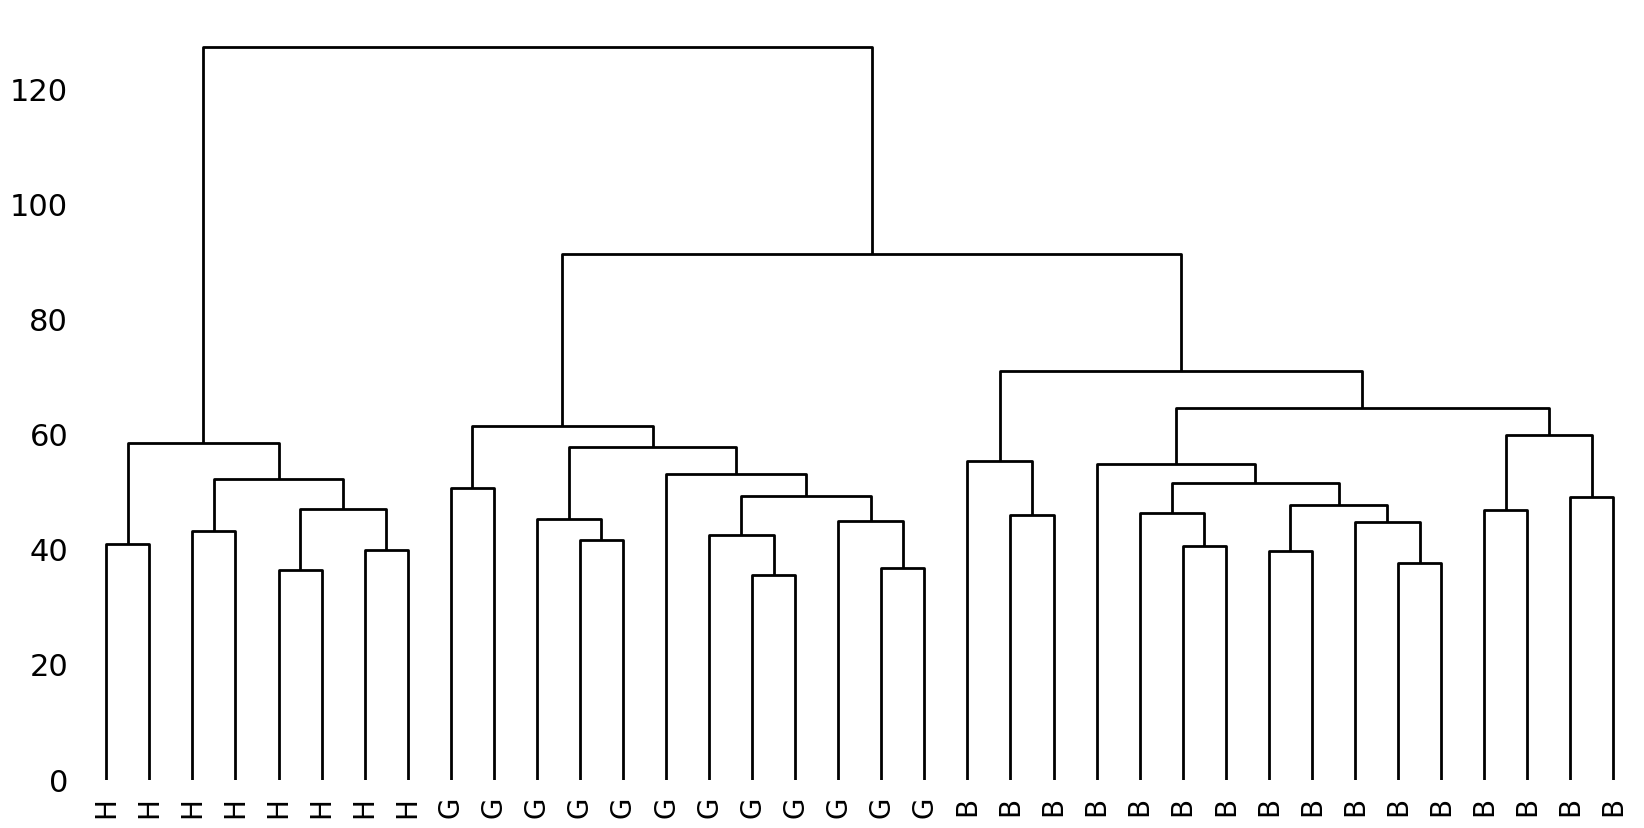

In [22]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

# 1. Calculate pairwise distances
dm = scidist.pdist(v_documents, 'cityblock')

# 2. Establish branch structure
linkage_object = hierarchy.linkage(dm, method='complete')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(10, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

plot_tree(linkage_object, authors)

<!-- Figure: Dendrogram cluster visualization of 10,000-lemma samples from the epistolary collections by Hildegard, Bernard, and Guibert.\label{fig-stylometry-example-dendrogram} -->

The tree should be read from bottom to top, where the original texts are displayed as the
tree's leaf nodes. When moving to the top, we see how these original nodes are
progressively being merged in new nodes by vertical branches. Subsequently, these newly
created, non-original nodes are eventually joined into higher-level nodes and this process
continues until all nodes have been merged into a single root node at the top. On the
vertical axis, we see numbers which we can read as the distance between the various
nodes: the longer the branches that lead up to a node, the more distant the nodes that are
being merged. The cluster analysis performs well: the tree splits into three coherent
clusters, each consisting solely of texts from one author.

How do the documents with unknown authorship fit into this tree? After "stacking" their
document vectors to those of the entire corpus, we rerun the cluster analysis, which
produces the tree below. 

```{note}
The reader should note that we use the function `transform()` on
the `vectorizer` and `scaler`, rather than `fit()` or `fit_transform()`, because we do not
wish to re-fit these and use them in the exact same way as they were applied to the texts
of undisputed authorship.
```

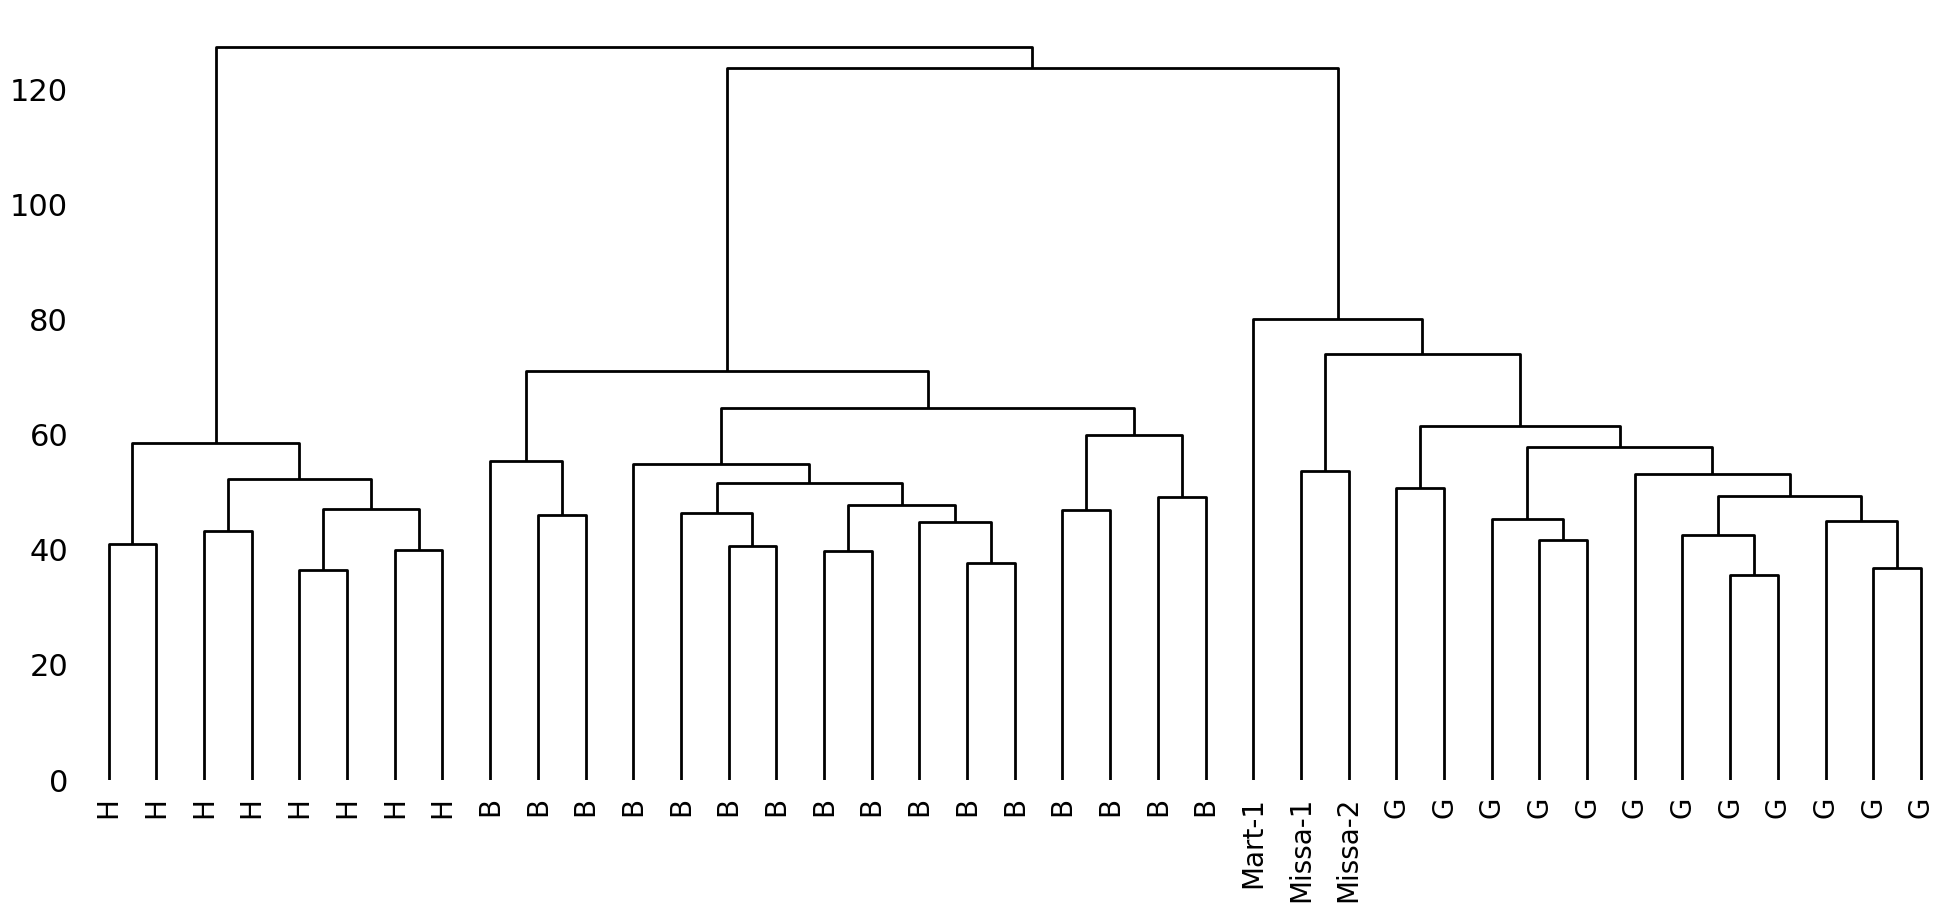

In [23]:
v_test_docs = vectorizer.transform(test_docs[1:])
v_test_docs = preprocessing.normalize(v_test_docs.astype(float), norm='l1')
v_test_docs = scaler.transform(v_test_docs.toarray())

all_documents = np.vstack((v_documents, v_test_docs))

dm = scidist.pdist(all_documents, 'cityblock')
linkage_object = hierarchy.linkage(dm, method='complete')

plot_tree(linkage_object, authors + test_titles[1:], figsize=(12, 5))

<!-- Figure: Dendrogram of the epistolary collections by Hildegard, Bernard, and Guibert (10,000-lemma samples), as well as three test texts of which the authorial provenance is disputed.\label{fig-stylometry-test-dendrogram} -->

Interestingly, and even without normalizing the document length (to unclutter the
visualization), the disputed texts are clustered together with documents written by
Guibert of Gembloux. The relatively high branching position of `D_Mart.txt` suggests that
it is not at the core of his writings, but the similarities are still striking. The
cluster analysis thus adds some nuance to our prior results, and provides new hypotheses
worth exploring. In the next section, we will explore a second "clustering" technique to
add yet another perspective to the mix.


(sec-stylometry-pca)=
## Principal Component Analysis

In this final section, we will a cover a common technique in stylometry, called <span class="index">Principal
Component Analysis</span> (or <span class="index">PCA</span>). PCA stems from multivariate statistics, and has been applied
regularly to literary corpora in recent years {cite:p}`binongoEA:1999,hoover2007corpus`. PCA is
a useful technique for textual analysis because it enables intuitive visualizations of
corpora. The document-term matrix created earlier represents a $36 \times 65$ matrix:
i.e., we have 36 documents (by 3 authors) which are each characterized in terms of 65 word
frequencies. The columns in such a matrix are also called dimensions, because our texts
can be considered points in a geometric space that has 65 axes. We are used to plotting
such points in a geometric space that only has a small number of axes (e.g., 2 or 3), using
the pairwise coordinates, reflecting their score in each dimension. Let us plot, for
instance, these texts with respect to two randomly selected dimensions (i.e., those
representing *super* and *propter*):

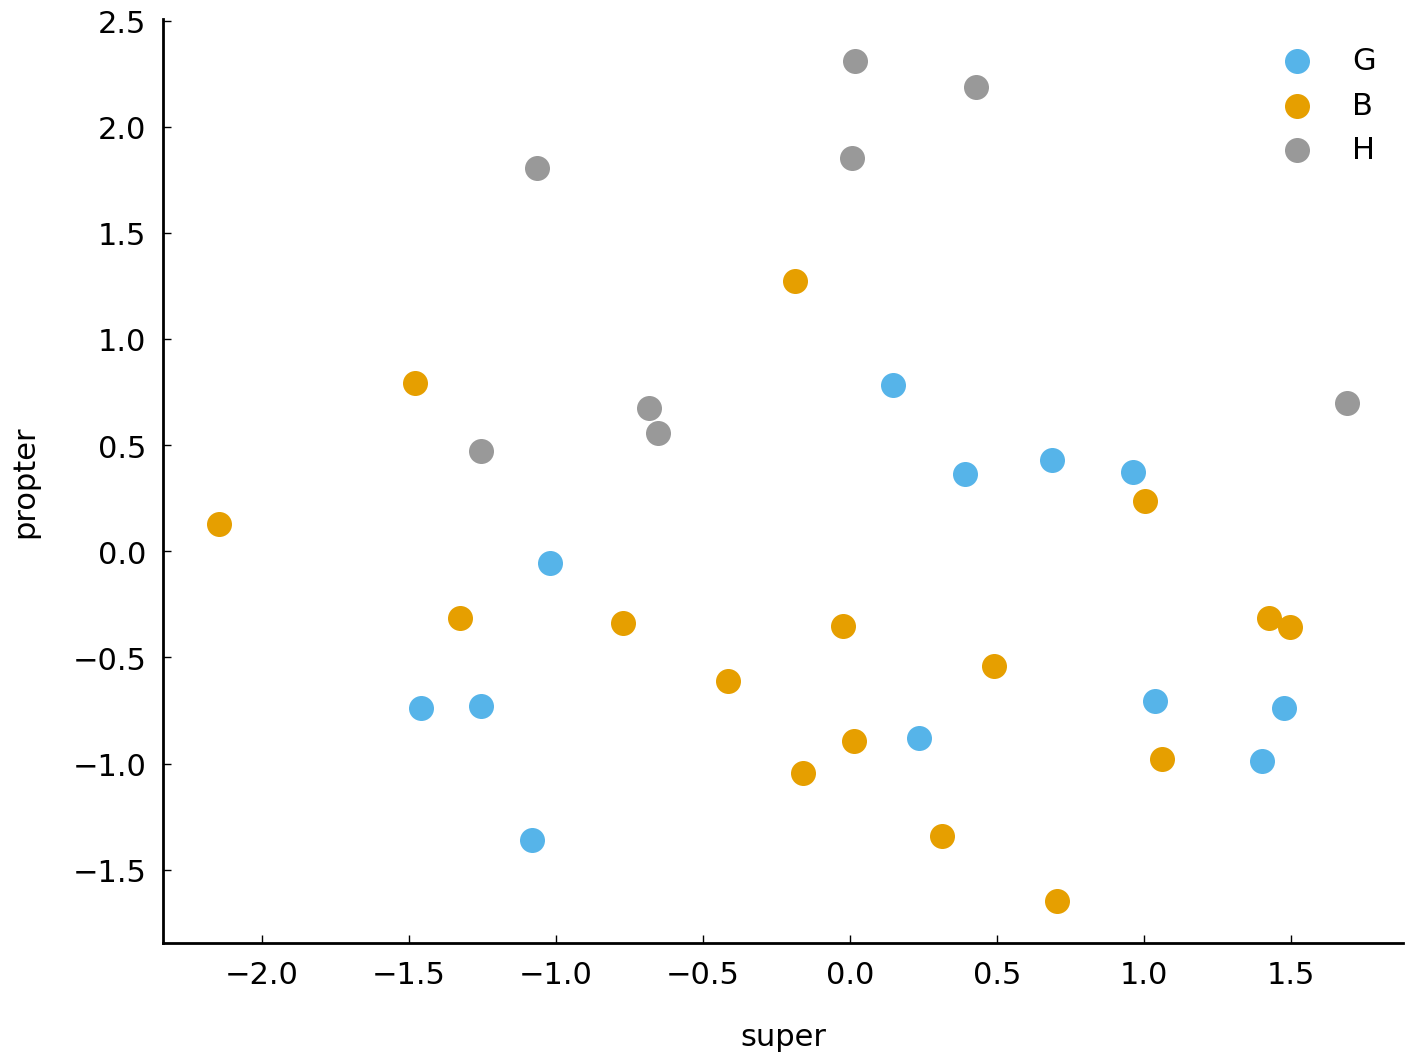

In [24]:
words = list(vectorizer.get_feature_names_out())
authors = np.array(authors)
x = v_documents[:, words.index('super')]
y = v_documents[:, words.index('propter')]

fig, ax = plt.subplots()
for author in set(authors):
    ax.scatter(x[authors==author], y[authors==author], label=author)
ax.set(xlabel='super', ylabel='propter')
plt.legend();

<!-- Figure: A two-dimensional visualization of the distances between 36 writing samples by -->
<!-- three authors (Hildegard of Bingen (H), Guibert of Gembloux (G), and Bernard of Clairvaux -->
<!-- (B)) in terms of two word variables.\label{fig-stylometry-2d-scatter-plot-dots} -->

To make our plot slightly more readable, we could plot the author's name for each text,
instead of multi-colored dots. For this, we first need to plot an empty scatter plot, with
invisible points using `scatter()`. Next, we overlay these points in their vertical and
horizontal center with a string label. The resulting plot is shown below:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: "Roboto Condensed Regular"


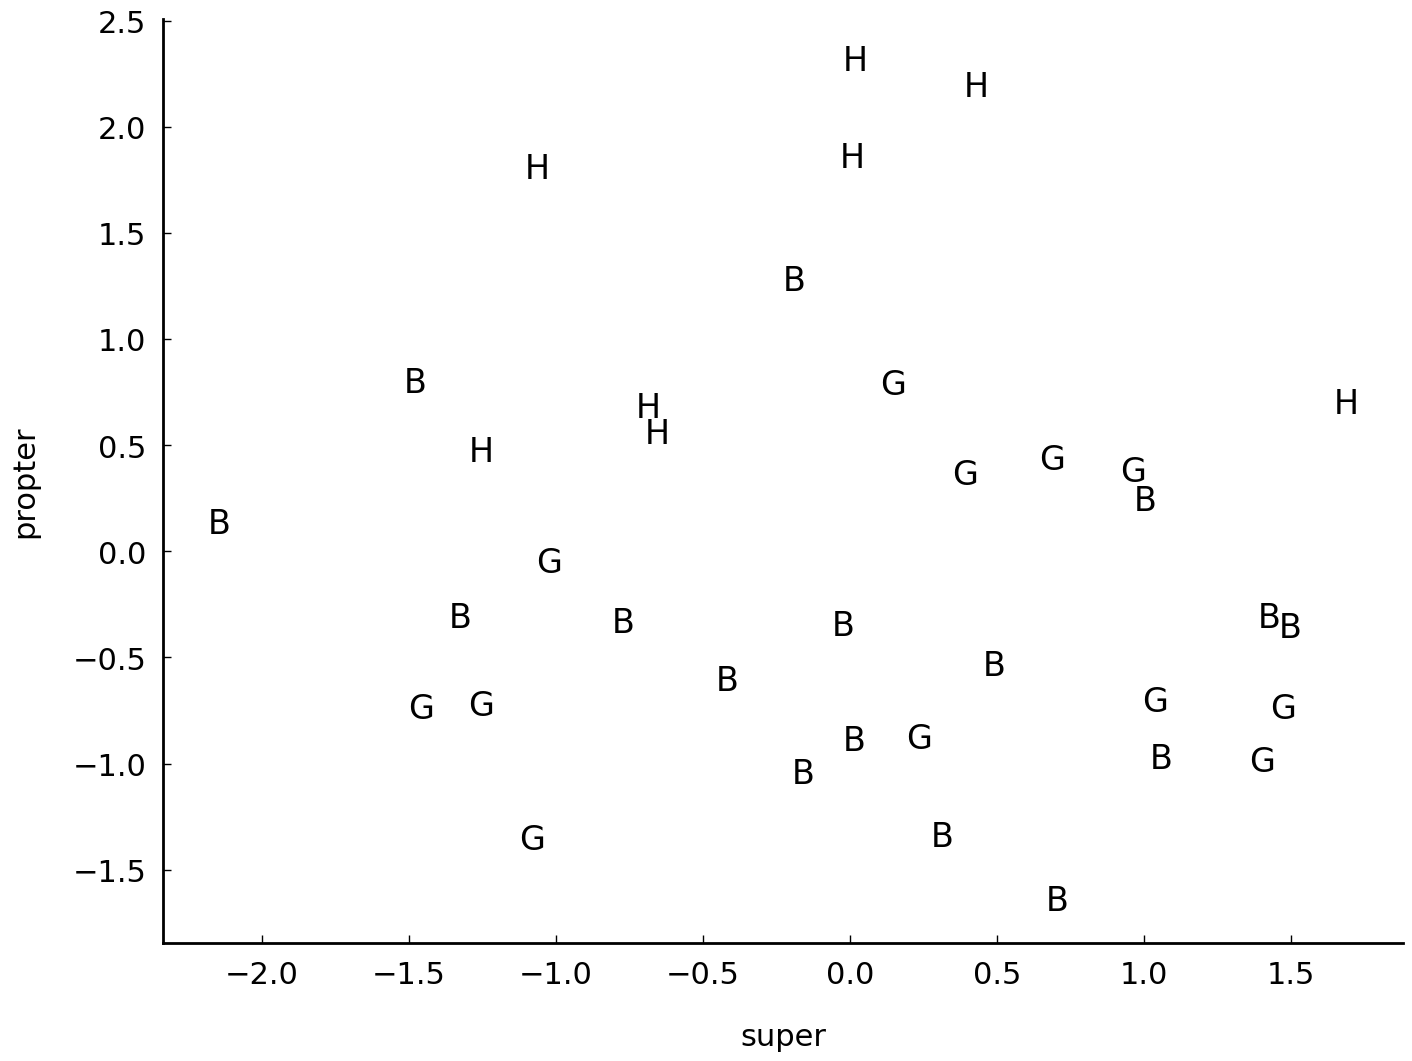

In [25]:
fig, ax = plt.subplots()
ax.scatter(x, y, facecolors='none')
for p1, p2, author in zip(x, y, authors):
    ax.text(p1, p2, author[0], fontsize=12,
            ha='center', va='center')
ax.set(xlabel='super', ylabel='propter');

<!-- Figure: A two-dimensional visualization of the distances between 36 texts by three authors -->
<!-- (Hildegard of Bingen (H), Guibert of Gembloux (G), and Bernard of Clairvaux (B)) in terms -->
<!-- of two word variables.\label{fig-stylometry-2d-scatter-plot} -->

The sad reality remains that we are only inspecting 2 of the 65 variables that we have for
each data point. Humans have great difficulties imagining, let alone plotting, data in
more than 3 dimensions simultaneously. Many real-life datasets even have much more than 65
dimensions, so that the problem becomes even more acute in those cases. PCA is one of the
many techniques which exist to reduce the dimensionality of datasets. The general idea
behind <span class="index">dimensionality reduction</span> is that we seek a new
representation of a dataset, which needs much less dimensions to characterize our data
points, but which still offers a maximally faithful approximation of our data. PCA is
prototypical approach to text modeling in stylometry, because we create a much smaller
model which we know beforehand will only be an approximation of our original dataset. This
operation is often crucial for scholars who deal with large datasets, where the number of
features is much larger that the number of data points. In stylometry, it is very common
to reduce the dimensionality of a dataset to as little as 2 or 3 dimensions.

### Applying PCA

Before going into the intuition behind this technique, it makes sense to get a rough idea
of the kind of output which a PCA can produce. Nowadays, there are many Python libraries
which allow you to quickly run a PCA. The aforementioned scikit-learn library has a very
efficient, uncluttered object for this. Below, we instantiate such an object and use it to
reduce the dimensionality of our original $36 \times 65$ matrix:

In [26]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)

print(v_documents.shape)
print(documents_proj.shape)

(36, 65)
(36, 2)


Note that the shape information shows that the dimensionality of our new dataset is indeed
restricted to `n_components`, the parameter which we set at 2 when calling the `PCA`
constructor. Each of these newly created columns is called a "<span
class="index">principal component</span>" (PC), and can be expected to describe an
important aspect about our data. Apparently, the PCA has managed to provide a
two-dimensional "summary" of our data set, which originally contained 65 columns. Because
our dataset is now low-dimensional, we can plot it using the same plotting techniques that
were introduced above.

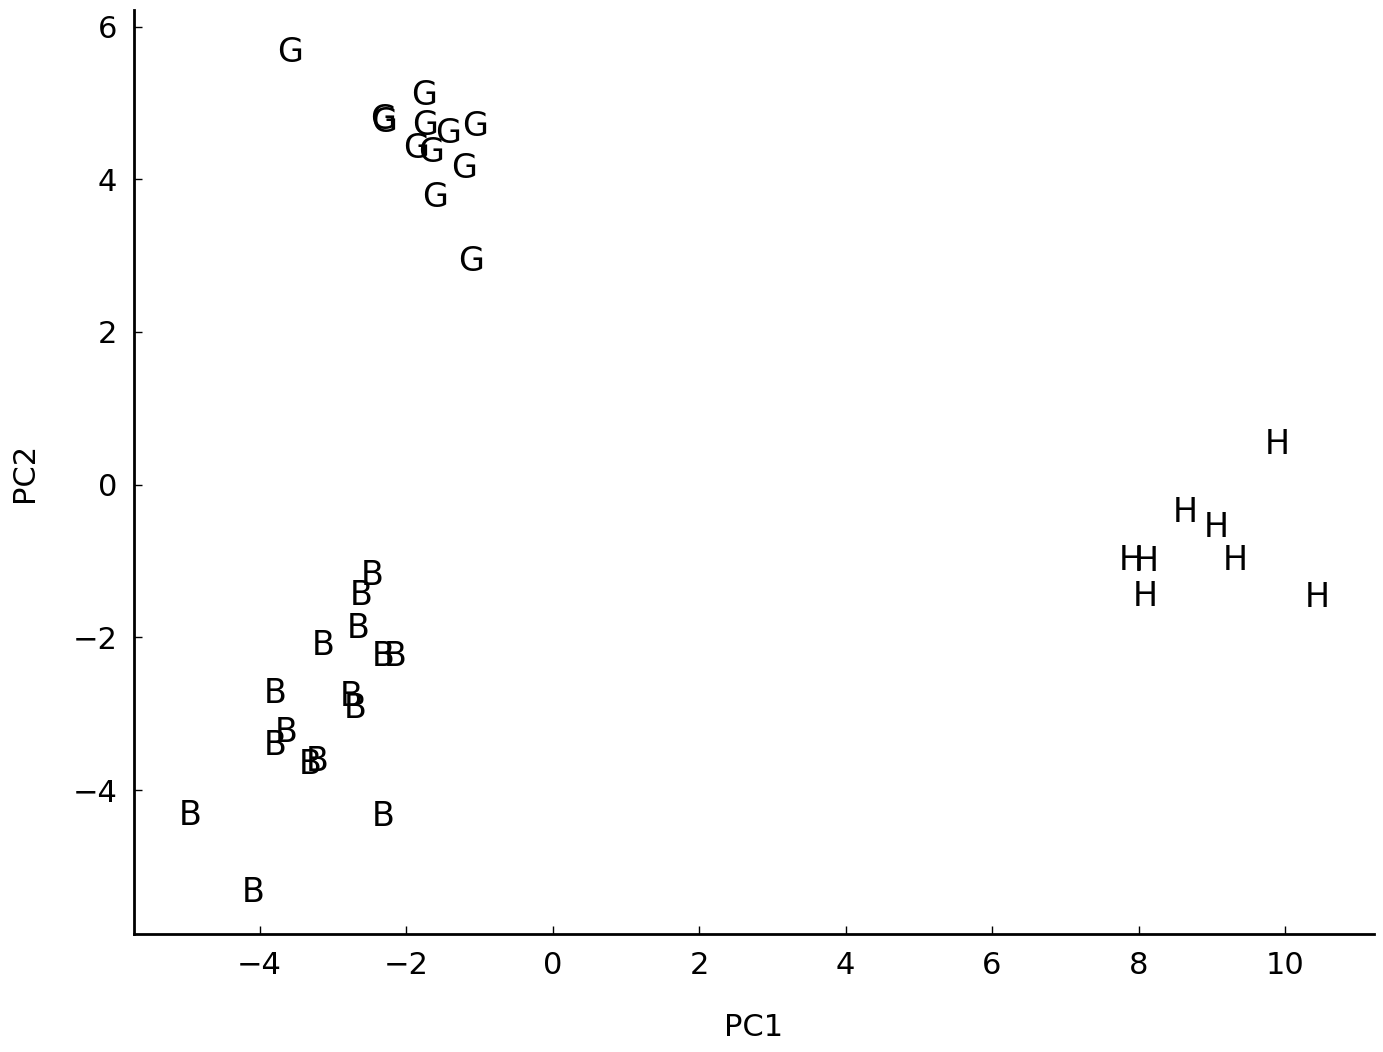

In [27]:
c1, c2 = documents_proj[:, 0], documents_proj[:, 1]

fig, ax = plt.subplots()
ax.scatter(c1, c2, facecolors='none')

for p1, p2, author in zip(c1, c2, authors):
    ax.text(p1, p2, author[0], fontsize=12,
            ha='center', va='center')

ax.set(xlabel='PC1', ylabel='PC2');

<!-- Figure: A scatterplot displaying 36 texts by 3 authors in the first two components of a -->
<!-- PCA.\label{fig-stylometry-2d-pca-plot} -->

By convention, we plot the first component on the horizontal axis and the second component
on the vertical axis. The resulting plot displays much more authorial structure: the texts
now form very neat per-author clusters. Like hierarchical clustering, <span
class="index">PCA</span> too is an <span class="index">unsupervised</span> method: we
never included any provenance information about the texts in the analysis. Therefore it is
fascinating that the analysis still seems to be able to automatically distinguish between
the writing styles of our three authors. The first component is responsible for the
horizontal distribution of our texts in the plot; interestingly, we see that this
component primarily manages to separate Hildegard from her two male contemporaries. The
second component, on the other hand, is more useful to distinguish Bernard of Clairvaux
from Guibert of Gembloux on the vertical axis. This is also clear from the more simplistic
visualization shown below, which was generated by the following lines of code:

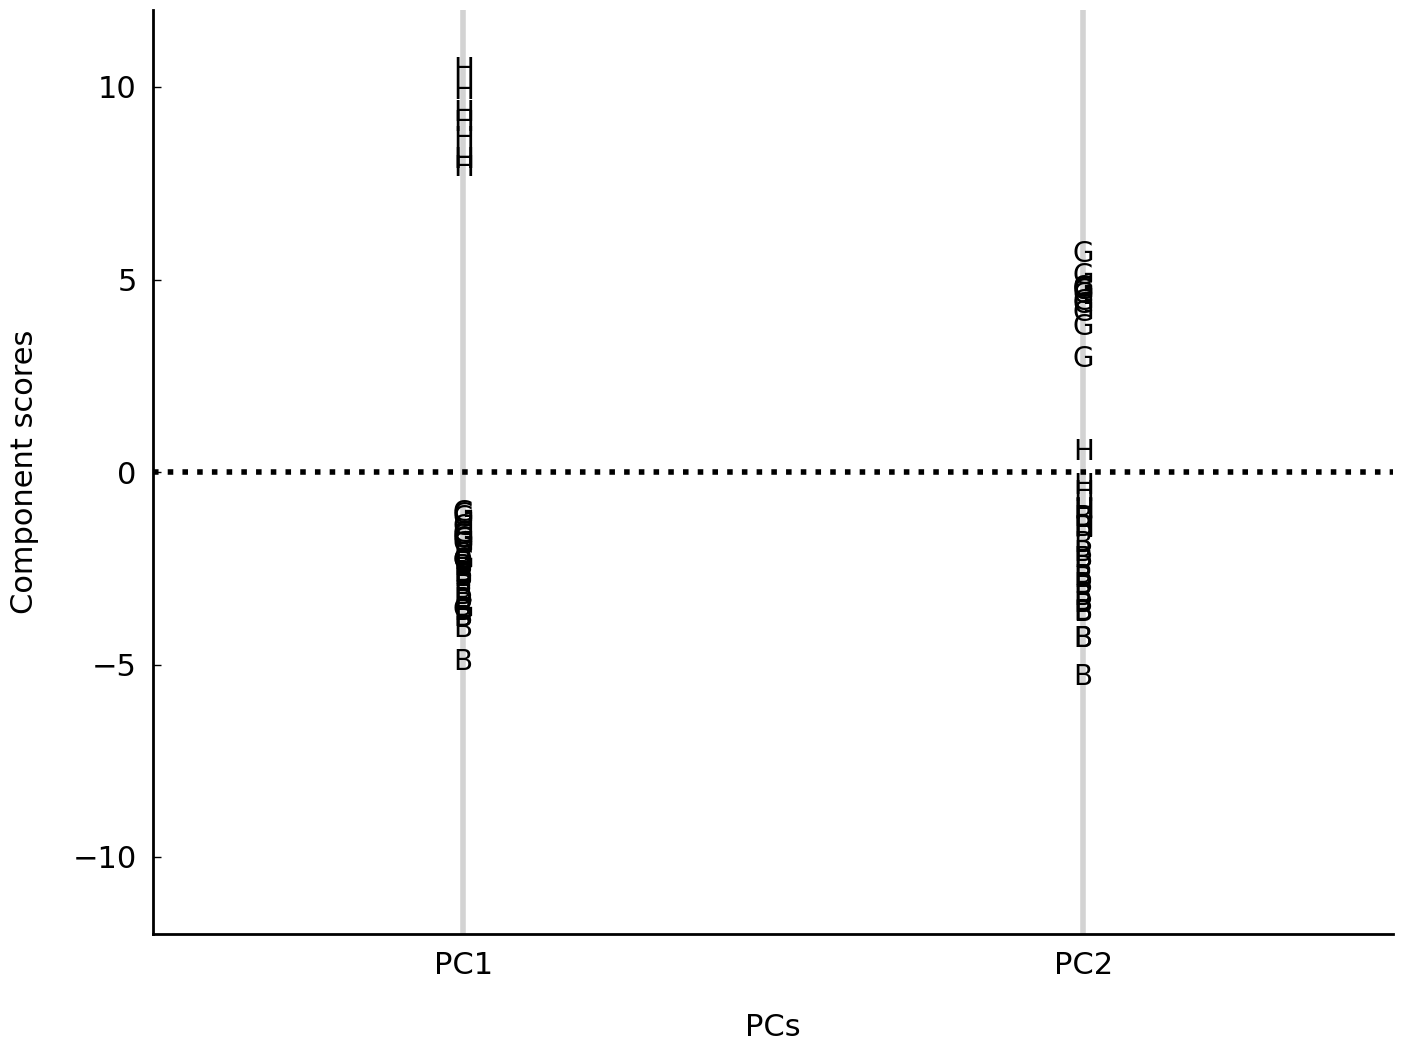

In [28]:
fig, ax = plt.subplots()

for idx in range(pca.components_.shape[0]):
    ax.axvline(idx, linewidth=2, color='lightgrey')
    for score, author in zip(documents_proj[:, idx], authors):
        ax.text(
            idx, score, author[0], fontsize=10,
            va='center', ha='center')

ax.axhline(0, ls='dotted', c='black')
ax.set(
    xlim=(-0.5, 1.5), ylim=(-12, 12),
    xlabel='PCs', ylabel='Component scores',
    xticks=[0, 1], xticklabels=["PC1", "PC2"]);

<!-- Figure: Displaying 36 writing samples by three authors in the first (PC1) and second (PC2) components of -->
<!-- a PCA separately. PC1 and PC2 realize different distinctions between the three authors.\label{fig-stylometry-pca-visualization-authors} -->

Note how the distribution of samples in the first component realizes a clear distinction
between Hildegard and the rest. The clear distinction collapses in the second component, but,
interestingly, this second component shows a much clearer opposition between the two other authors.

### The intuition behind PCA

How does PCA work? A formal description of PCA requires some familarity with
linear algebra (see, for example, {cite:t}`shlens2014tutorial`). When analyzing texts in terms of
word frequencies, it is important to realize that there exist many subtle correlations
between such frequencies. Consider the pair of English articles *the* and *a*: whenever a
text shows an elevated frequency of the definite article, this increases the likelihood
that the indefinite article will be less frequent in that same text. That is because *the*
and *a* can be considered "positional synonyms": these articles can never appear in the
same syntactic slot in a text (they exclude each other), so that authors, when creating
noun phrases, must choose between one of them. This automatically entails that if an
author has a clear preference for indefinite articles, (s)he will almost certainly use less
definite articles. Such a correlation between *two* variables could in fact also be
described by a single new variable $y$. If a text has a high score for this abstract
variable $y$, this could mean that (s)he uses a lot of definite articles but much less
indefinite articles. A low, negative score for $y$ might on the other hand represent the
opposite situation, where an author clearly favors indefinite over definite
articles. Finally, a $y$-score of zero could mean that an author does not have a clear
preference. This abstract $y$-variable is a simple example but it can be
likened to a principal component. A PCA too will attempt to compress the information
contained in word frequencies, by coming up with new, compressed components that
decorrelate this information and summarize it into a far smaller number of
dimensions. Therefore, PCA will often indirectly detect subtle oppositions between texts
that are interesting in the context of authorship attribution. Let us take back a number
of steps:

In [29]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(v_documents)

print(pca.components_.shape)

(2, 65)


We get back a matrix of which the shape ($2 \times 65$) will look familiar: we have two
principal components (cf. `n_components`) that each have a score for the original word
features in the original document-term matrix. Another interesting property of the `pca`
object is the <span class="index">explained variance ratio</span>:

In [30]:
pca = sklearn.decomposition.PCA(n_components=36)
pca.fit(v_documents)

print(len(pca.explained_variance_ratio_))

36


The `explained_variance_ratio_` attribute has a score for each of the 36 principal
components in our case. These are normalized scores and will sum to 1:

In [31]:
print(sum(pca.explained_variance_ratio_))

1.0


Intuitively, the *explained variance* expresses for each PC how much of the
original variance in our dataset it retains, or, in other words, how accurately it offers a
summary of the original data when considered in isolation. Components are typically ranked
according to this criterium, so that the first principal component (cf. the horizontal
dimension above) is the PC which, in isolation, preserves most of the original variation in
the original data. Typically, only 2 or 3 components are retained, because when taken
together, one will often see that these PCs already explain the bulk of the original variance,
so that the rest can be safely dropped. Also, components that have an explained variance <
0.05 are typically ignored because they add very little information in the end
{cite:p}`baayen:2008`. We can visualize this distribution using a small bar plot, where the bars
indicate the explained variance for and in which we also keep track of the cumulative
variance that is explained as we work our way down the component list.

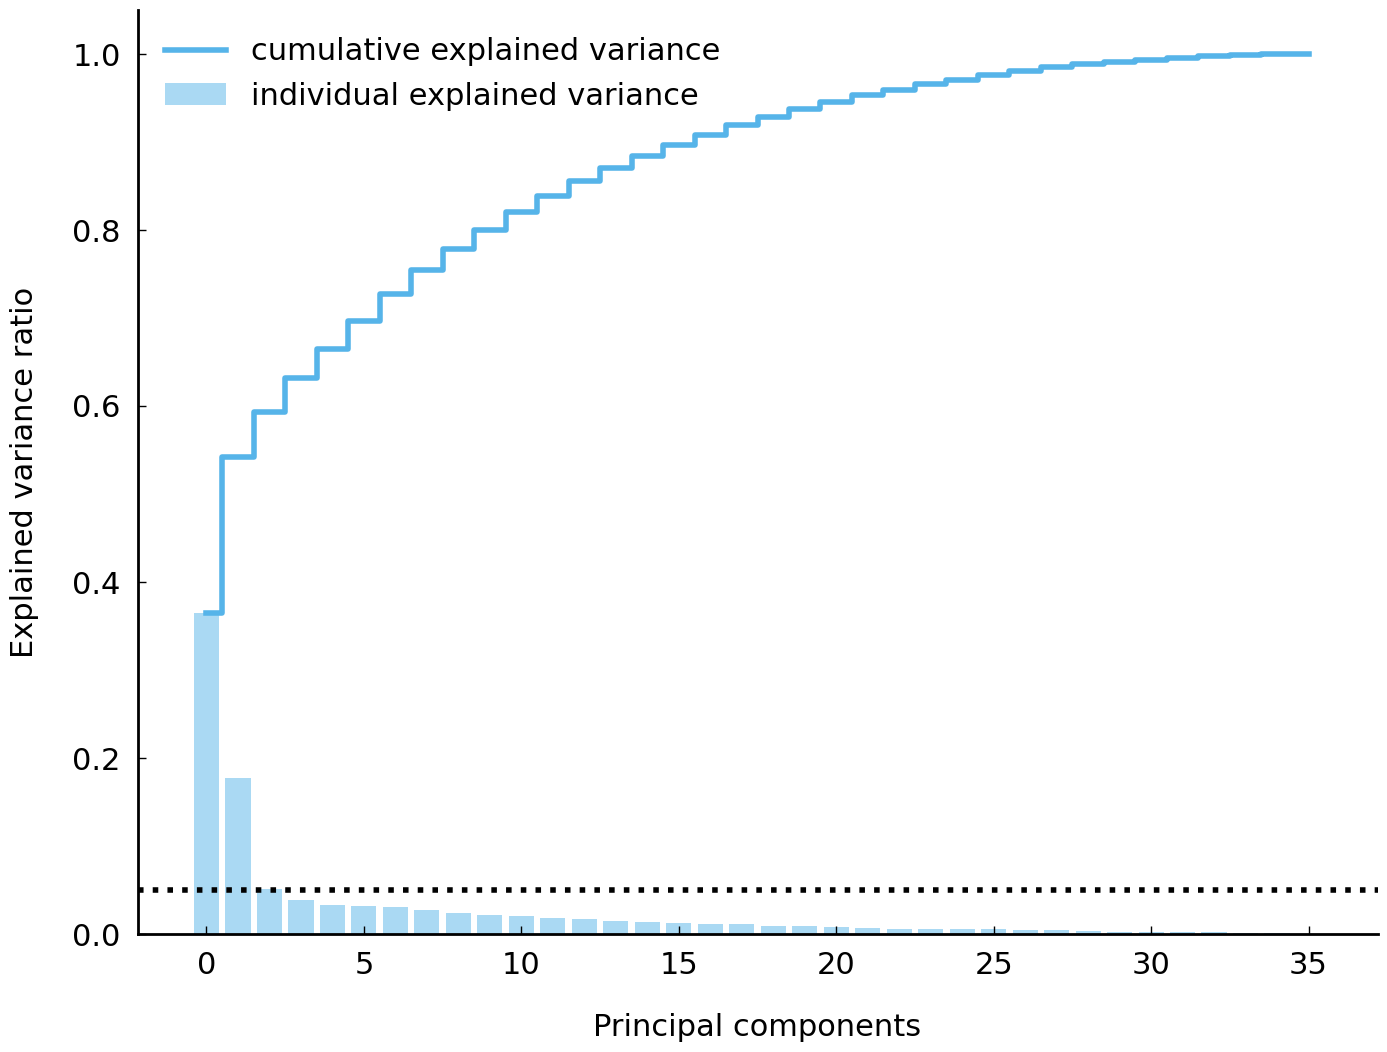

In [32]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

fig, ax = plt.subplots()

ax.bar(range(36), var_exp, alpha=0.5, align='center',
        label='individual explained variance')

ax.step(range(36), cum_var_exp, where='mid',
         label='cumulative explained variance')

ax.axhline(0.05, ls='dotted', color="black")
ax.set(ylabel='Explained variance ratio', xlabel='Principal components')
ax.legend(loc='best');

<!-- Figure: Cumulative and individual explained variance in the component list.\label{fig-stylometry-cimulative-explained-variance} -->

As you can see, the first three components together explain a large proportion of the
original variance; the subsequent PCs add relatively little, with only the first few PCs reaching
the 0.05 level (which is plotted as a dotted black line). Surprisingly, we see that the first
component alone can account for a very large share of the total variance. In terms of
modeling, the explained variance score is highly valuable: when you plot texts
in their first two components as we did, it is safe to state that the total variance
explained amounts to the following plain sum:

In [33]:
print(var_exp[0] + var_exp[1])

0.5418467851530999


Thus, the PCA does not only yield a visualization, but it also yields a score expressing
how faithful this representation is with respect to the original data. This score is on
the one hand relatively high, given the fact that we have reduced our complete dataset to
a compressed format of just two columns. On the other hand, we have to remain aware that
the other components might still capture relevant information about our texts that a
two-dimensional visualization does not show.

### Loadings

What do the components, yielded by a PCA, look like? Recall that, in scikit-learn, we
can easily inspect these components after a `PCA` object has been fitted:

In [34]:
# HIDE THIS CELL:
# SET PRINTING FOR NEXT CELL
np.set_printoptions(threshold=50)

In [35]:
pca = sklearn.decomposition.PCA(n_components=2).fit(v_documents)
print(pca.components_)

[[-0.01261718 -0.17502663  0.19371289 ... -0.05284575  0.15797111
  -0.14855212]
 [ 0.25962781  0.0071369   0.05184334 ... -0.05141676 -0.06927065
   0.04312771]]


In [36]:
# HIDE THIS CELL:
# RESET PRINTING
np.set_printoptions(threshold=1000)

In fact, applying the fitted `pca` object to new data (i.e., the `transform()` step),
comes down to a fairly straightforward multiplication of the original data matrix with the
component matrix. The only step which scikit-learn adds is the subtraction of the columnwise
mean in the original matrix, to center values around a mean of zeros. (Don't mind the
<span class="index">`transpose()`</span> method for now, we will explain it shortly.)

In [37]:
X_centered = v_documents - np.mean(v_documents, axis=0)
X_bar1 = np.dot(X_centered, pca.components_.transpose())
X_bar2 = pca.transform(v_documents)

The result is, as you might have expected, a matrix of shape $36 \times 2$, i.e., the
coordinate pairs which we already used above. The <span class="index">`numpy.dot()`</span>
function which we use in this code block refers to a so-called <span class="index">dot
product</span>, which is a specific type of matrix multiplication (cf. chapter
{ref}`chp-vector-space-model`). Such a <span class="index">matrix multiplication</span> is
also called a linear transformation, where each new component will assign a specific
weight to each of the original feature scores. These weights, i.e., the numbers contained
in the components matrix, are often also called <span class="index">loadings</span>,
because they reflect how important each word is to each PC. A great advantage of PCA is
that it allows us to inspect and visualize these weights or loadings in a very intuitive
way, which allows us to interpret the visualization in an even more concrete way: we can
plot the word loadings in a scatter plot too, since we can align the component scores with
the original words in our vectorizer's vocabulary. For our own convenience, we first
transpose the component matrix, meaning that we flip the matrix and turn the row vectors
into column vectors.

In [38]:
print(pca.components_.shape)
comps = pca.components_.transpose()
print(comps.shape)

(2, 65)
(65, 2)


This is also why we needed the `transpose()` method a couple of code blocks ago, since we
needed to make sure that dimensions of both `X` and the `components` matrix matched. We
can now more easily "zip" this transposed matrix with our vectorizer's vocabulary, and sort
these words according to their loadings on PC1:

In [39]:
import operator

vocab = vectorizer.get_feature_names_out()
vocab_weights = sorted(zip(vocab, comps[:, 0]), key=operator.itemgetter(1), reverse=True)

We can now inspect the top and bottom of this ranked list to find out which items have the
strongest loading (either positive or negative) on PC1:

In [40]:
print('Positive loadings:')
print('\n'.join(f'{w} -> {s}' for w, s in vocab_weights[:5]))

Positive loadings:
in -> 0.19371288677377668
ita -> 0.18241992378624636
per -> 0.18115806688500907
uelut -> 0.1801888293185639
unde -> 0.1762194975035874


In [41]:
print('Negative loadings:')
print('\n'.join(f'{w} -> {s}' for w, s in vocab_weights[-5:]))

Negative loadings:
quam -> -0.16396980041076892
iam -> -0.16589861024232344
magis -> -0.16743388326578998
aut -> -0.17037738587759382
qui -> -0.17502663330844656


Now that we understand how each word has a specific "weight" or importance for each
component, it becomes clear that, instead of the texts, we should also be able to plot the
words in the two-dimensional space, defined by the component matrix. The visualization is
shown below; the underlying code runs entirely parallel to our previous scatter plot code:

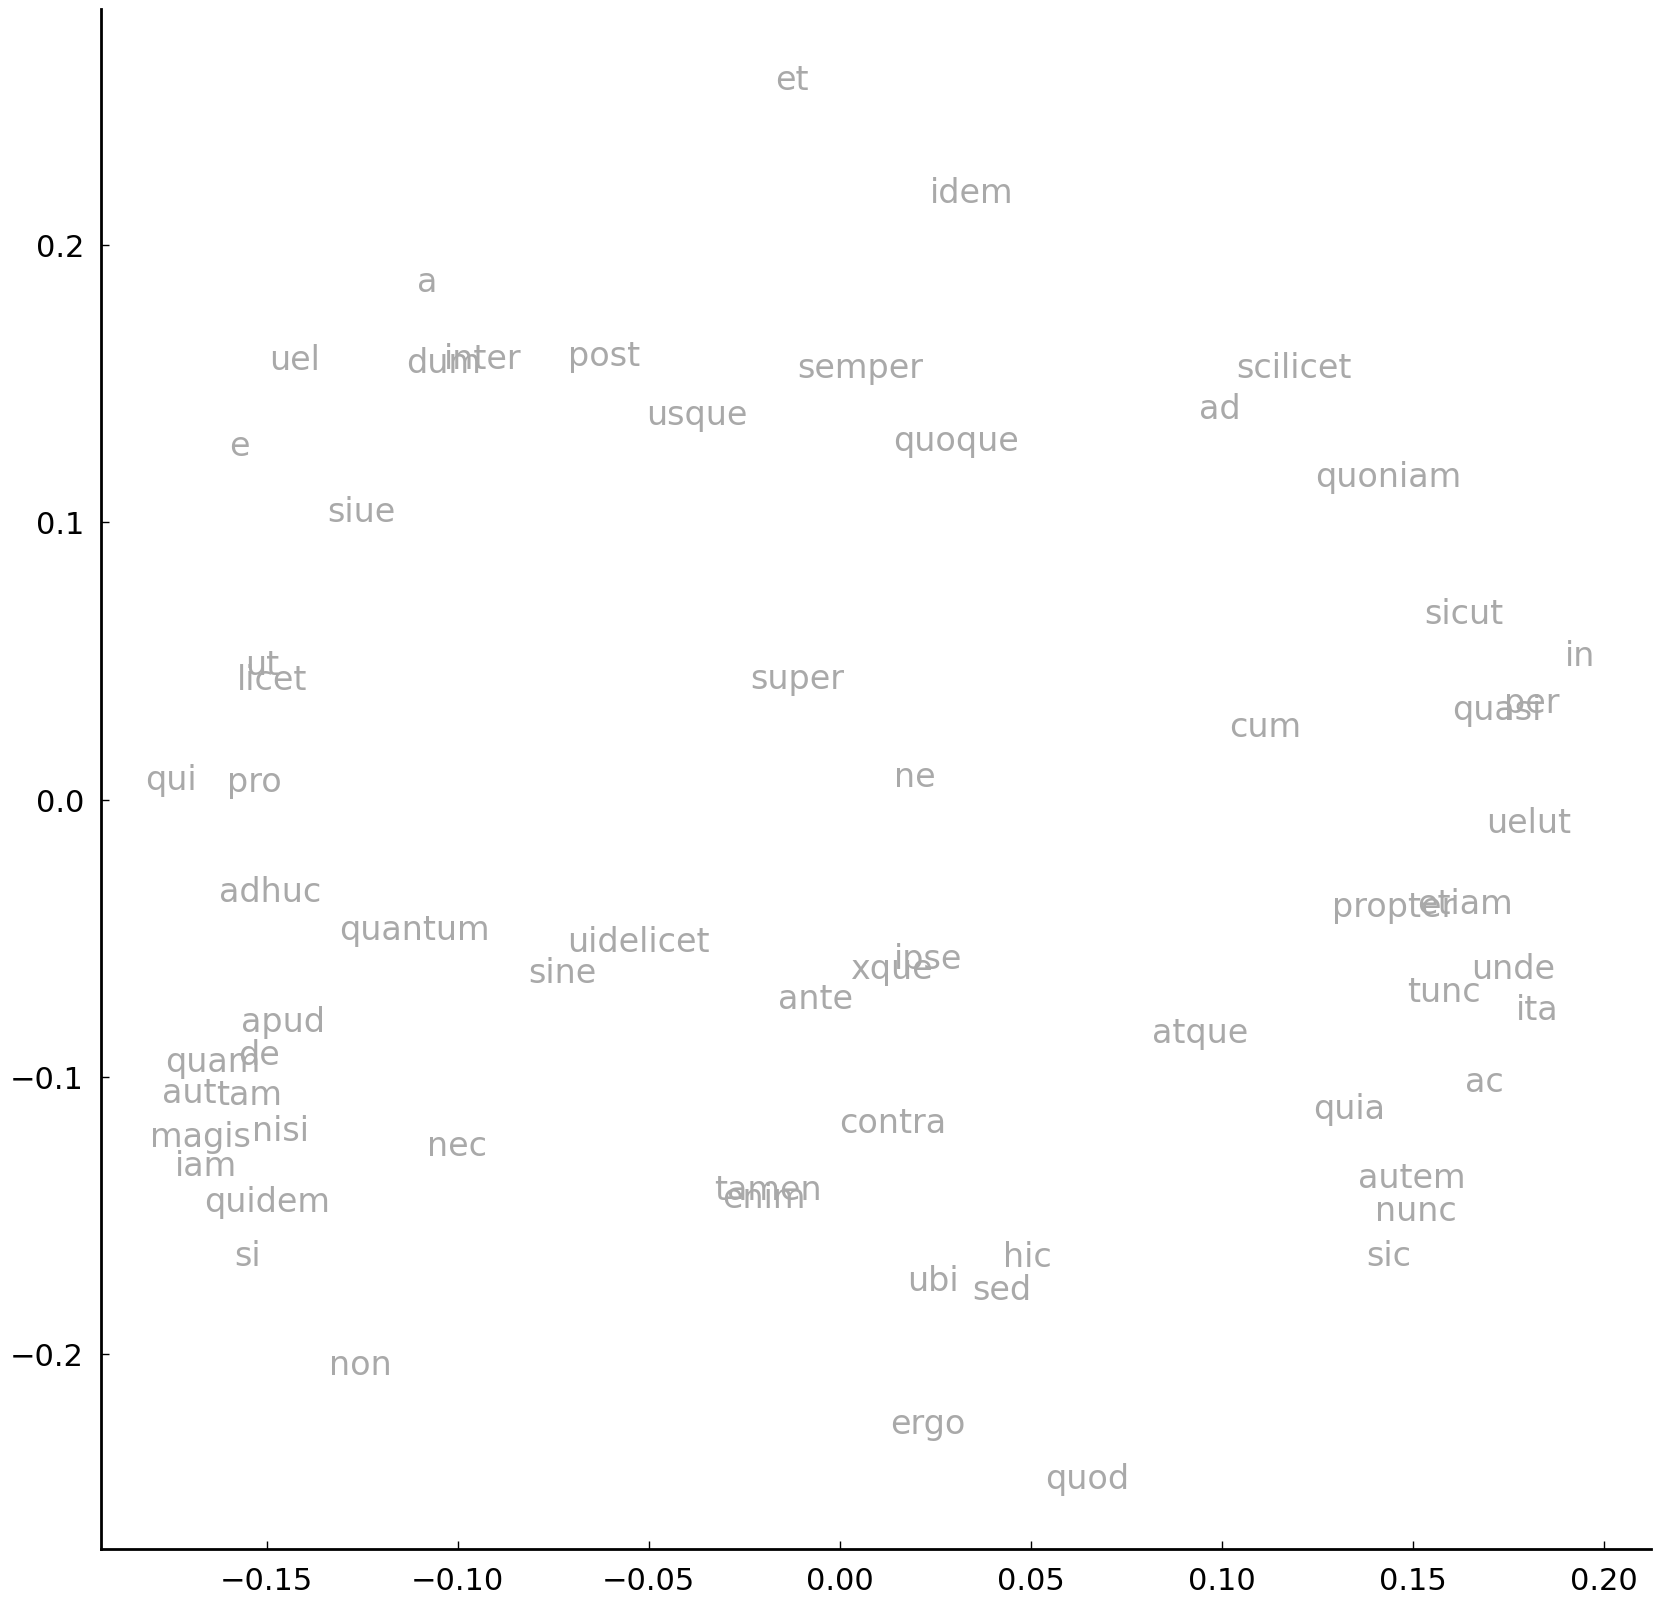

In [42]:
l1, l2 = comps[:, 0], comps[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(l1, l2, facecolors='none')

for x, y, l in zip(l1, l2, vocab):
    ax.text(x, y, l, ha='center', va='center', color='darkgrey', fontsize=12)

<!-- Figure: Word loadings for a PC analysis (first two dimensions) on 9 texts by 3 authors -->
<!-- (texts not displayed here).\label{fig-stylometry-word-loadings} -->

It becomes truly interesting if we first plot our texts, and then overlay this
plot with the loadings plot. We can do this by plotting the loadings on the so-called <span class="index">twin
axis</span>, opposite of the axes on which we first plot our texts. A full example, which adds
additional information, reads as follows. 
<!-- The resulting visualization is shown in Figure {ref}`fig-stylometry-word-loadings-authors`. -->

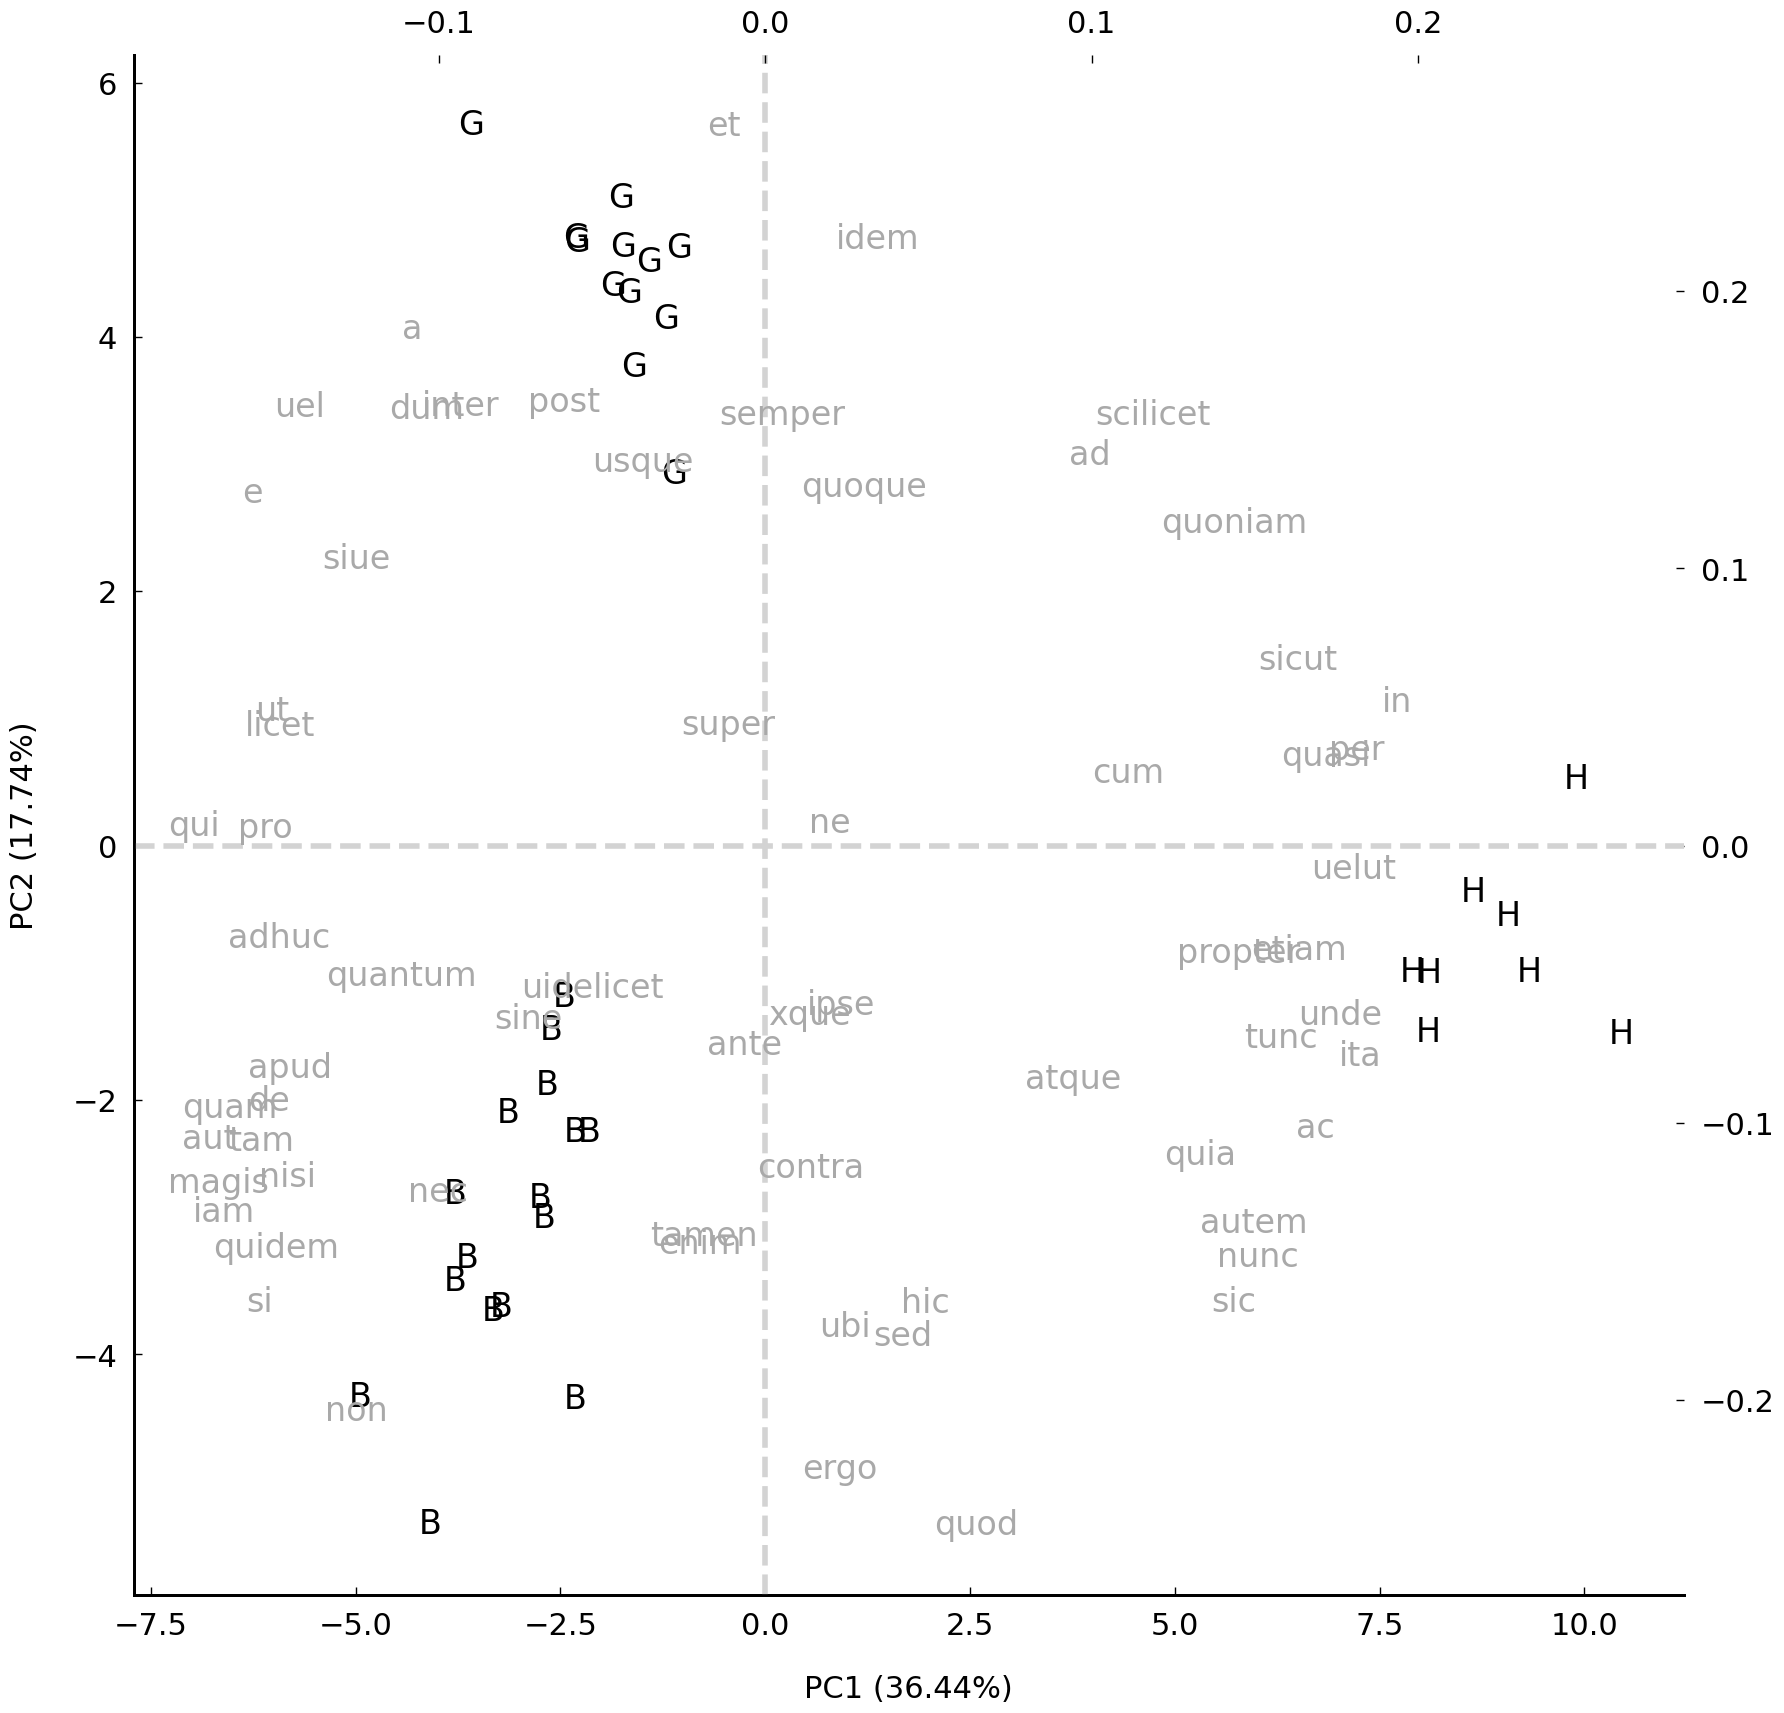

In [43]:
import mpl_axes_aligner.align

def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author in zip(x1, x2, labels):
        color = 'red' if author not in ('H', 'G', 'B') else 'black'
        text_ax.text(p1, p2, author, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')

    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    loadings_ax.scatter(l1, l2, facecolors='none');
    for x, y, loading in zip(l1, l2, vectorizer.get_feature_names_out()):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, authors)

<!-- Figure: Word loadings for a PC analysis (first two dimensions) on texts by three -->
<!-- authors. Both axes (PCs and loadings) have been properly -->
<!-- aligned.\label{fig-stylometry-word-loadings-authors} -->

Such plots are great visualizations because they show the main stylistic structure in a
dataset, together with an indication of how reliable each component is. Additionally, the
loadings make clear which words have played an important role in determining the
relationships between texts. Loadings which can be found to the far left of the plot can
be said to be typical of the texts plotted in the same area. As you can see in this
analysis, there are a number of very common lemmas which are used in rather different ways
by the three authors: Hildegard is a frequent user of *in* (probably because she always
describes things she witnessed *in* visions), while the elevated use of *et* reveals the
use of long, paratactic sentences in Guibert's prose. Bernard of Clairvaux uses *non*
rather often, probably as a result of his love for antithetical
reasonings. Metaphorically, the loadings can be interpreted as little "magnets": when
creating the scatter plot, you can imagine that the loadings are plotted first. Next, the
texts are dropped in the middle of the plot and then, according to their word frequencies,
they are attracted by the word magnets, which will eventually determine their position in
the diagram.

Therefore, loading plots are a great tool for the interpretation of the results of a
PCA. A cluster tree acts much more like a black box in this respect, but these dendrograms
can be used to visualize larger datasets. In theory, a PCA visualization that is
restricted to just two or three dimensions is not meant to visualize large datasets that
include more than ca. three to four oeuvres, because two dimensions can only visualize so much
information {cite:p}`binongoEA:1999`. One final advantage, from a theoretical perspective, is
that PCA explicitly tries to model the correlations which we know exist between word
variables. Distance metrics, such as the Manhattan distance used in Delta or cluster analyses,
are much more naïve in this respect, because they do not explicitly model such subtle
correlations.

We are now ready to include the other texts of disputed authorship in this
analysis---these are displayed in red in the figure below, but we exclude the previously
analyzed test text by Bernard of Clairvaux. We have arrived at a stage in our analysis
where the result should look reasonably similar to the graph which was shown in the
beginning of the chapter, because we followed the original implementation as closely as
possible. The texts of doubtful provenance are clearly drawn to the area of the space
which is dominated by Guibert's samples (indicated with the prefix *G_*): the scatter plot
therefore reveals that the disputed documents are much more similar, in term of function
word frequencies, to the oeuvre of Guibert of Gembloux, Hildegard's last secretary, than to
works of the mystic herself. The very least we can conclude from this analysis is that
these writing samples cannot be considered typical of Hildegard's writing style, which
should fuel doubts about their authenticity, in combination with other historic evidence.

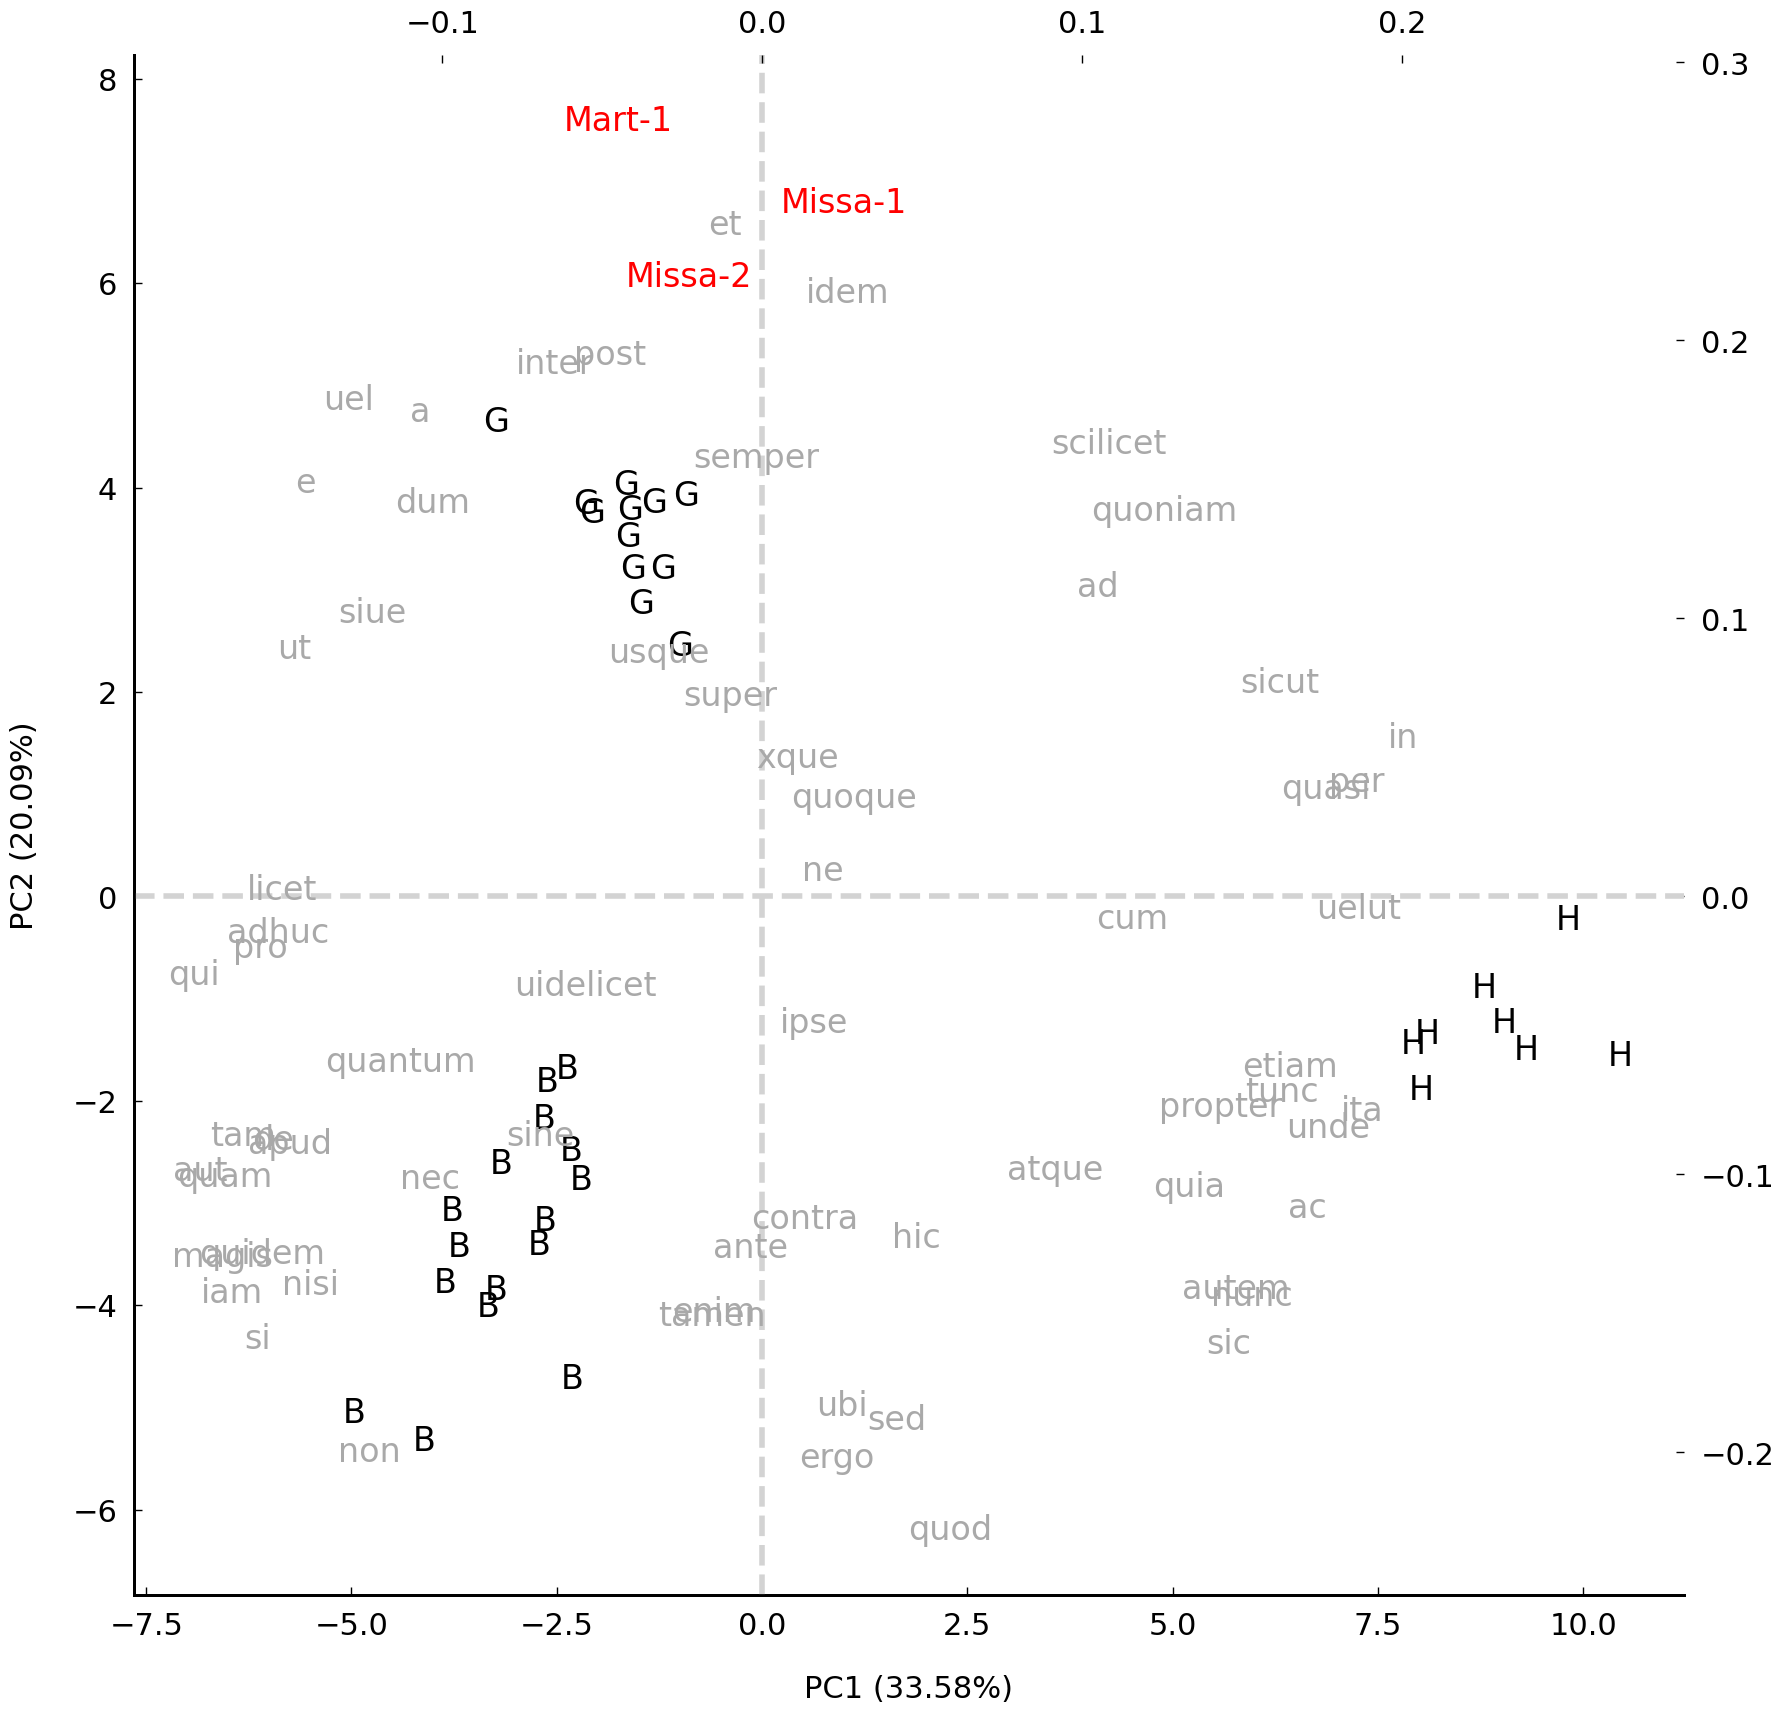

In [44]:
all_documents = preprocessing.scale(np.vstack((v_documents, v_test_docs)))
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(all_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, list(authors) + test_titles[1:])

<!-- Figure: Word loadings for a PC analysis (first two dimensions) on 9 texts by three -->
<!-- authors. Red texts indicate disputed authorship.\label{fig-stylometry-word-loadings-authors-aligned-missing-texts} -->

## Conclusions

Authorship is an old and important problem in philology but, nowadays, stylistic
authentication problems are studied in a much more diverse set of fields, including forensic
linguistics and internet safety studies. Computational modeling brings added value to
many societally relevant problems as such and is often less biased than human readers in
performing this difficult task. Any serious authentication study in the humanities,
however, should not rely on hard numbers alone: additional, text-external evidence must
always be carefully taken into account and whenever one encounters an attribution result
that diametrically opposes results obtained by conventional studies, that should be a
cause for worry. 

At the same time, stylometry often brings fresh quantitative evidence to the table that
might call into question preconveived ideas about the authorship of texts. The case study
presented above, for instance, raised interesting questions about a text, of which the
authorship for centuries went undisputed. At the same, the reader should note that the
Hildegard scholars involved in this research (Jeroen Deploige and Sarah Moens) still
chose to edit the disputed texts as part of Hildegard *opera omnia*, because the ties to
her oeuvre were unmistakable. This should remind us that authorship and authenticity are
often more a matter of (probabilistic) degree than of a (boolean) kind. Exactly because of
these scholarly gradients, quantitative approaches are useful to help objectify our own
intuitions. 

## Further Reading

The field of stylometry is a popular and rapidly evolving branch of digital text
analysis. Technical introductions and tutorials nevertheless remain sparse in the field,
especially for Python. Baayen's acclaimed book on linguistic analysis in R contains a
number of useful sections {cite:p}`baayen:2008`, as does Jockers's introductory book
{cite:p}`jockers:2014`. On the topic of authorship specifically, three relatively technical
survey papers are typically listed as foundational readings: {cite:t}`koppelEA:2009`,
{cite:t}`stamatatos:2009`, and {cite:t}`juola:2006`. A number of recent companions, such as
{cite:t}`schreibmanEA2004` or {cite:t}`siemensEA2008`, contain relevant chapters on stylometry and
quantitative stylistics.

## Exercises

### Easy

<span class="index">Julius Caesar</span> (100--44 BC), the famous Roman statesman, was also an accomplished writer of
Latin prose. He is famous for his collection of war commentaries, including the *Bellum
Civile*, offering an account of the civil war, and the *Bellum Gallicum*, where he
reports on his military expeditions in Gaul. Caesar wrote the bulk of these texts
himself, with the exception of book eight of the Gallic Wars, which is believed to have
been written by one of Caesar's generals, Aulus Hirtius. Three other war commentaries
survive in the Caesarian tradition, which have sometimes been attributed to Caesar
himself: the Alexandrian War (*Bellum Alexandrinum*), the African War (*Bellum
Africum*), and the Spanish War (*Bellum Hispaniense*). It remains unclear, however, who
actually authored these: Caesar’s ancient biographer Suetonius, for instance, suggests
that either Hirtius or another general, named Oppius, authored the remaining works.

{cite:t}`kestemontEA:2016` argue using stylometric arguments that, in all likelihood, Hirtius
indeed authored one of these other works, whereas the other two commentaries were
probably not written by either Caesar or Hirtius. Although this publication used a fairly
complex authorship verification technique, a plain cluster analysis, like the one
introduced in the previous section, can also be used to set up a similar argument. This is
what we will do in the following set of exercises.

The dataset is stored as a compressed tar archive, `caesar.tar.gz`, which can be
decompressed using the following lines of code:

In [45]:
import tarfile

tf = tarfile.open('data/caesar.tar.gz', 'r')
tf.extractall('data')

After decompressing the archive, you can find a series of texts under `data/caesar`, which
represent consecutive 1000-word segments which we extracted from these works. The plain
text file `caesar_civ3_6.txt`, for instance, represents the sixth 1000-word sample from
the third book of the civil war commentary by Caesar, whereas Hirtius's contributions to
book 8 of the Gallic Wars take the prefix `hirtius_gall8`. Samples containing the codes
`alex`, `afric`, and `hispa` contain samples of the dubious war commentaries.

1. Load the texts from disk, and store them in a list (`texts`). Keep a descriptive label
   for each text (e.g., `gall8`) in a parallel list (`titles`) and fill yet another list
   (`authors`) with the author labels. How many texts are there in the corpus?
2. Convert the texts into a vector space model using the `CountVectorizer` object, and
   keep only the 10,000 most frequent words. Print the shape of the vector space model,
   and confirm that the number of rows and columns is correct.
3. Normalize the counts into relative frequencies (i.e., apply $L1$ normalization).

### Moderate
1. Use the normalized frequencies to compute the pairwise distances between all documents
   in the corpus. Choose an appropriate distance metric, and motivate your choice.
2. Run a hierarchical agglomerative cluster analysis on the computed distance matrix. Plot
   the results as a dendrogram using the function `plot_tree()`. Which of the dubious texts
   is generally closest in style to Hirtius's book 8?
3. Experiment with some other distance metrics and recompute the dendrogram. How does the
   choice for a particular distance metric impact the results?

### Challenging

<span class="index">Jack the Ripper</span> is one of the most famous and notorious serial
killers of the nineteenth century. Perhaps fueled by the fact that he was never
apprehended or identified, the mystery surrounding the murders in London's Whitechapel
district has only grown with time. Around the time of the murders (and also in the
following years), Jack allegedly sent numerous letters to the police announcing and / or
describing his crimes, which shrouded the crimes in even deeper mystery. However, there
are several reasons why the authenticity of most of these letters has always remained
contentious.

In a recent study, {cite:t}`nini:2018` sheds new light on the legitimacy of these letters using
stylometric methods. Nini explains that the legitimacy is doubtful since a significant
number of letters have been sent from different places all around the United Kingdom,
which, although not strictly impossible, makes it unlikely that they have the same
sender. As explained by {cite:t}`nini:2018`, this adds to the suspicion that many of these are hoax
letters, maybe even written by journalists, in an attempt to increase newspaper sales.

Nini's study focuses in particular on four early letters that were received not later than
October 1, 1888, by the London police: crucially, these letters antedate the wider 
publication among the general public of the contents of the earliest letters. The four
"prepublication" letters are marked in the dataset through the presence of the following
shorthand codes: `SAUCY JACKY, MIDIAN, DEAR BOSS, FROM HELL`. If these documents
were authored by the same individual, this would constitute critical historical evidence,
or, as Nini notes: "these four texts are particularly important because any linguistic
similarity that links them cannot be explained by influence from the media, an explanation
that cannot be ruled out for the other texts".

In the following exercises, we will try to replicate some of his findings, and assess
whether the "prepublication" letters were written by the same person.

1. The Jack the Ripper corpus used in {cite:t}`nini:2018` is saved as a compressed tar archive
   under `data/jack-the-ripper.tar.gz`. Load the text files in a list, and convert the
   filenames into a list of clearly readable labels (i.e., take the actual filename and
   remove the extension). Construct a vector space model of the texts using scikit-learn's
   `CountVectorizer`. From the original paper {cite:p}`nini:2018`, a number of crucial
   preprocessing details are available that allow you to approximate the author's approach
   when instantiating the `CountVectorizer`. Consult the online
   [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):
      - The paper relies on word bigrams as features (i.e., sequences of two consecutive
        words), rather than individual words or word "unigrams", as we have done before
        (cf. `ngram_range` parameter).
      - Since all texts are relatively short, Nini refrains from using actual frequencies
        (as these would likely be unreliable), and uses binary features instead
        (cf. `binary` parameter).
      - The author justifies at length why he chose to remove a small set of eight very common
        bigrams that occur in more than 20% of all documents in the corpus (cf. `max_df`
        parameter).
      - The author explicitly allows one-letter words into the vocabulary (e.g. *I* or
        *a*), so make sure to reuse the `token_pattern` regex used above and not the
        default setting.
   Finally, use `sklearn.preprocessing.scale()` to normalize the values in the resulting
   matrix in a column-wise fashion (`axis=1`).

2. Perform a hierarchical cluster analysis on the corpus using the Cosine Distance metric
   and Ward linkage (as detailed in the paper). The resulting tree will be hard to read,
   because it has many more leaf nodes than the examples in the chapter. First, read
   through the documentation of the `dendrogram()` function in
   `scipy.cluster.hierarchy`. Next, customize the existing `plot_tree()` function to improve
   the plot's readability:
     - Change the "orientation" argument to obtain a vertical tree (i.e., with the leaf
       nodes on the Y axis). In this new setup, you might also want to adapt the
       `leaf_rotation` argument.
     - Find a way to color the nodes of the prepublication letters. This is not trivial,
       since you will need to access the labels in the plot (*after* drawing it) but you
       also need to extract some information from the dictionary returned by the
       `dendrogram()` function.
     - Provide a generous `figsize` to make the resulting graph maximally readable (e.g.,
       `(10, 40)`).
     
   Do the results confirm {cite:t}`nini:2018`'s conclusions that some of the "prepublication
   letters" could very well be written by the same author? Which ones (not)?
     
3. A PCA as described in this chapter can help to gain more insight into the features
   underlying the distances between the texts. Run a PC analysis on the corpus, and plot
   your results using the `plot_pca()` function defined above. At first, however, the
   scatter plot will be very hard to read. Implement the following customizations to the
   existing code:
   - Color the prepublication letters in red.
   - Because the vocabulary is much larger than above, we need to unclutter the
     visualization. Restrict the number of loadings that you pass to `plot_pca()`, by
     selecting the loadings with the most extreme values for the first two components. One
     way of doing this is to multiply both component scores for each word with one another
     and then take the absolute value. If the resulting scores are properly ranked, the
     highest values will reveal the most extreme, and therefore most interesting, loadings.
   
   Nini argues that one of the four prepublications is of a different authorial provenance
   than the other three. Can you single out particular bigrams that are typical of this
   letter and untypical of the others?